In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import concurrent.futures

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 12})

In [2]:
def compute_values(mu_V_ratio, J_V_ratio, V, N, M, states, chemical_potential_loc = 0):
    """Compute energy gap for given parameters."""
    H = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio, chemical_potential_loc = chemical_potential_loc)
    eigenvalues, eigenvectors = exact_diagonalize(H)
    energy_gap = eigenvalues[1] - eigenvalues[0]
    second_energy_gap = eigenvalues[2] - eigenvalues[0]
    return energy_gap, second_energy_gap

def create_energy_gap_plot(N, M, V, mu_bounds = (0,2), J_bounds = (0, 2), resolution = 100, chemical_potential_loc = 1):
    
    min_J_V_ratio = J_bounds[0]
    max_J_V_ratio = J_bounds[1]
    max_mu_V_ratio = mu_bounds[1]
    
    mu_V_ratios = np.linspace(0, max_mu_V_ratio, resolution)
    J_V_ratios = np.linspace(min_J_V_ratio, max_J_V_ratio, resolution)
    mu_V_ratio_grid, J_V_ratio_grid = np.meshgrid(mu_V_ratios, J_V_ratios)

    energy_gap_over_V_grid = np.zeros_like(mu_V_ratio_grid)
    second_energy_gap_over_V_grid = np.zeros_like(mu_V_ratio_grid)
    states, _ = enumerate_states(N, M)

    # Use ThreadPoolExecutor for parallel processing
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_index = {}
        
        for i, mu_V_ratio in enumerate(mu_V_ratios):
            for j, J_V_ratio in enumerate(J_V_ratios):
                future = executor.submit(compute_values, mu_V_ratio, J_V_ratio, V, N, M, states, chemical_potential_loc)
                future_to_index[future] = (j, i)
        
        for future in concurrent.futures.as_completed(future_to_index):
            j, i = future_to_index[future]
            try:
                energy_gaps = future.result()
                energy_gap = energy_gaps[0]
                second_energy_gap = energy_gaps[1]
                
                energy_gap_over_V_grid[j, i] = energy_gap
                second_energy_gap_over_V_grid[j, i] = second_energy_gap
            except Exception as e:
                print(f"Error computing values for indices ({j}, {i}): {e}")

    J_V_ratios_full = np.concatenate((-J_V_ratios[::-1], J_V_ratios))  # mirroring data for J/V > 0 
    mu_V_ratios_full = mu_V_ratios
    J_V_ratio_grid_full, mu_V_ratio_grid_full = np.meshgrid(J_V_ratios_full, mu_V_ratios_full)
    energy_gap_full = np.concatenate((energy_gap_over_V_grid[::-1, :], energy_gap_over_V_grid), axis=0)
    second_energy_gap_full = np.concatenate((second_energy_gap_over_V_grid[::-1, :], second_energy_gap_over_V_grid), axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(J_V_ratio_grid_full.T, mu_V_ratio_grid_full.T, energy_gap_full, cmap="plasma", shading="auto")
    fig.colorbar(c, ax=ax, label="$\Delta E / |V|$")
    ax.set_xlabel("$J/|V|$")
    ax.set_ylabel("$μ/|V|$")
    ax.set_title(f"Energy Gap: N = {N}, M = {M}, V = {V} [μ @ m = {chemical_potential_loc}]")
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(J_V_ratio_grid_full.T, mu_V_ratio_grid_full.T, np.log(1/energy_gap_full), cmap="plasma", shading="auto", vmin = 0.1, vmax = 10)
    fig.colorbar(c, ax=ax, label="log$[|V| / \Delta E]$")
    ax.set_xlabel("$J/|V|$")
    ax.set_ylabel("$μ/|V|$")
    ax.set_title(f"Log Inverse Energy Gap: N = {N}, M = {M}, V = {V} [μ @ m = {chemical_potential_loc}]")
    fig.tight_layout()
    plt.show()
    
    """fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(J_V_ratio_grid_full.T, mu_V_ratio_grid_full.T, second_energy_gap_full, cmap="plasma", shading="auto")
    fig.colorbar(c, ax=ax, label="$\Delta E / |V|$")
    ax.set_xlabel("$J/|V|$")
    ax.set_ylabel("$μ/|V|$")
    ax.set_title(f"2nd Energy Gap: N = {N}, M = {M}, V = {V} [μ @ m = {chemical_potential_loc}]")
    fig.tight_layout()
    plt.show()"""
    
    """fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(J_V_ratio_grid_full.T, mu_V_ratio_grid_full.T, np.log(1/second_energy_gap_full), cmap="plasma", shading="auto")
    fig.colorbar(c, ax=ax, label="log$[\Delta E / |V|]$")
    ax.set_xlabel("$J/|V|$")
    ax.set_ylabel("$μ/|V|$")
    ax.set_title(f"Log Inverse 2nd Energy Gap: N = {N}, M = {M}, V = {V} [μ @ m = {chemical_potential_loc}]")
    fig.tight_layout()
    plt.show()"""

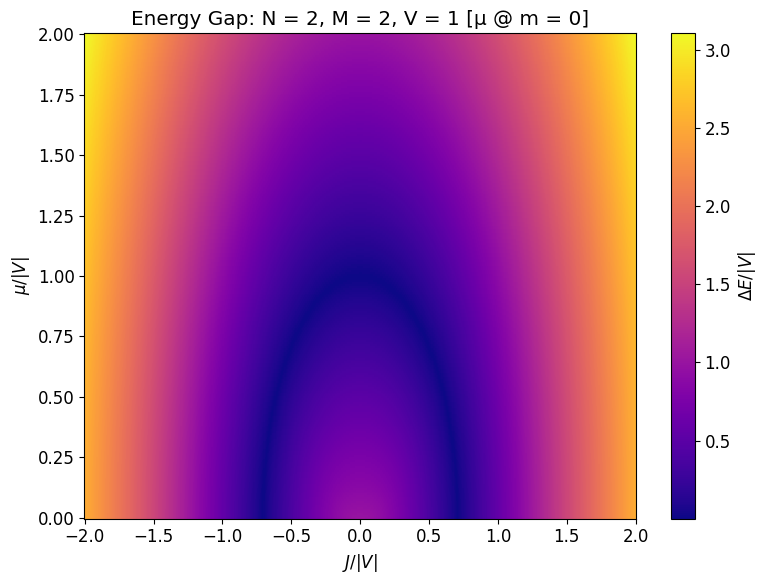

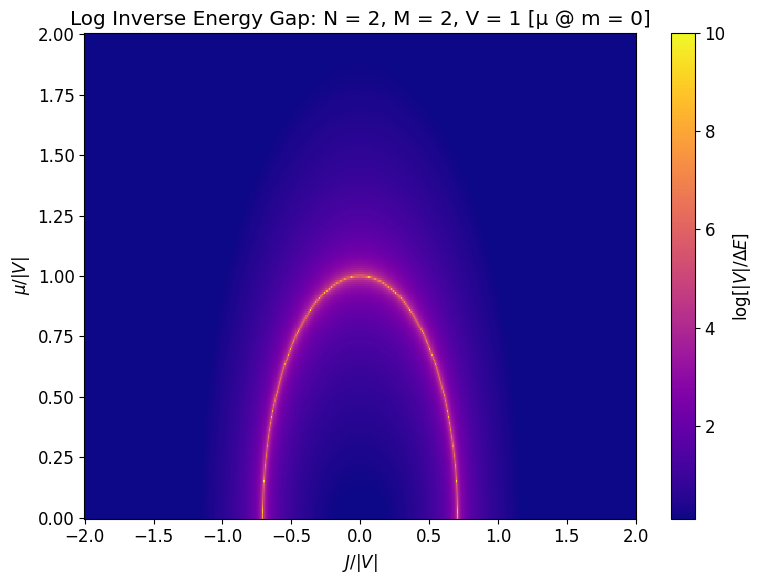

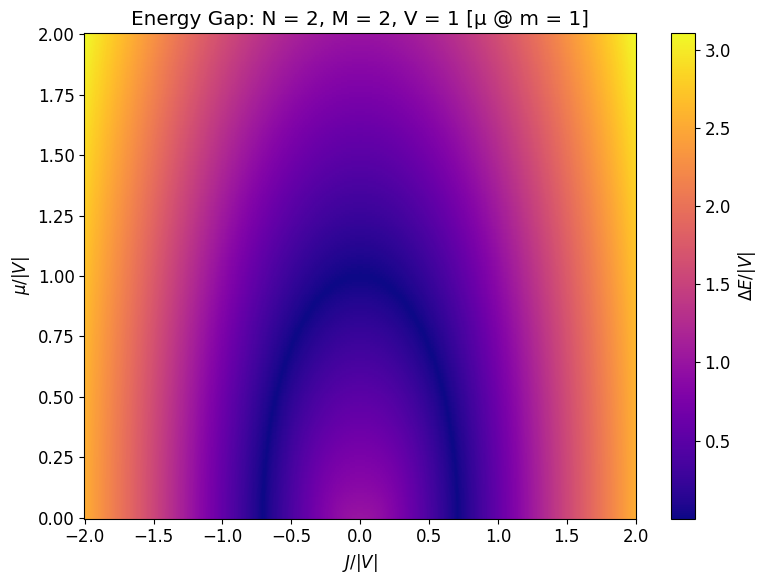

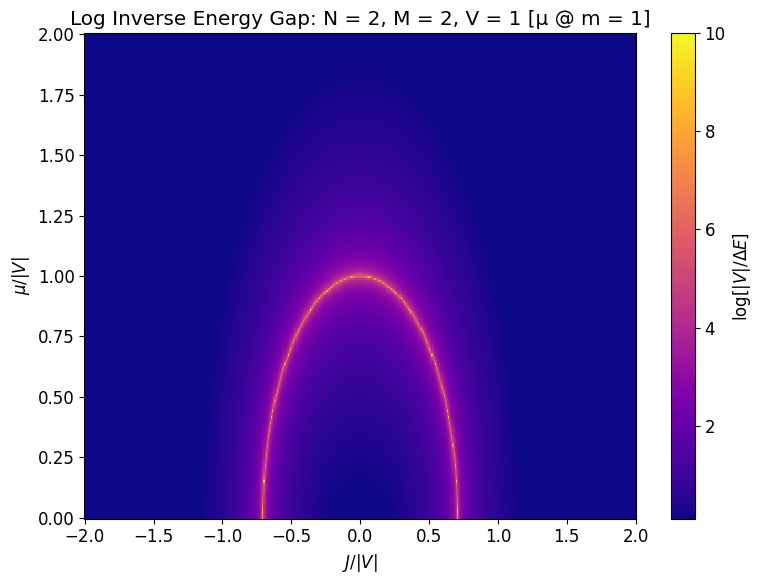

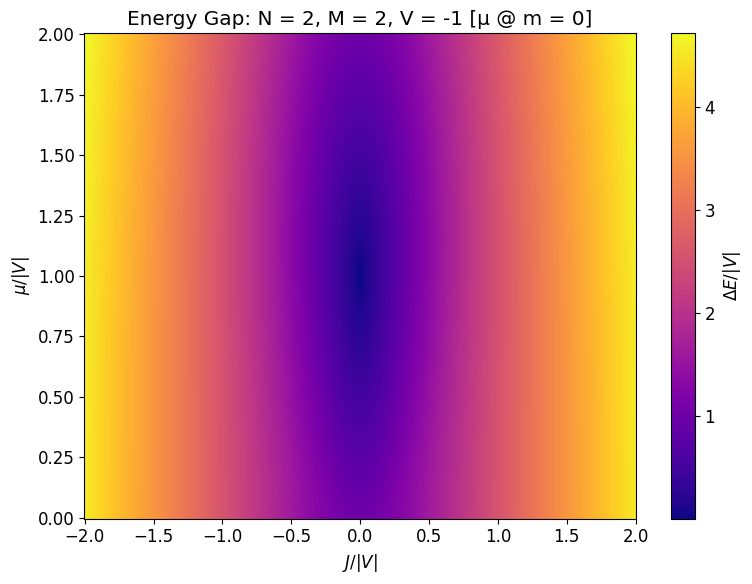

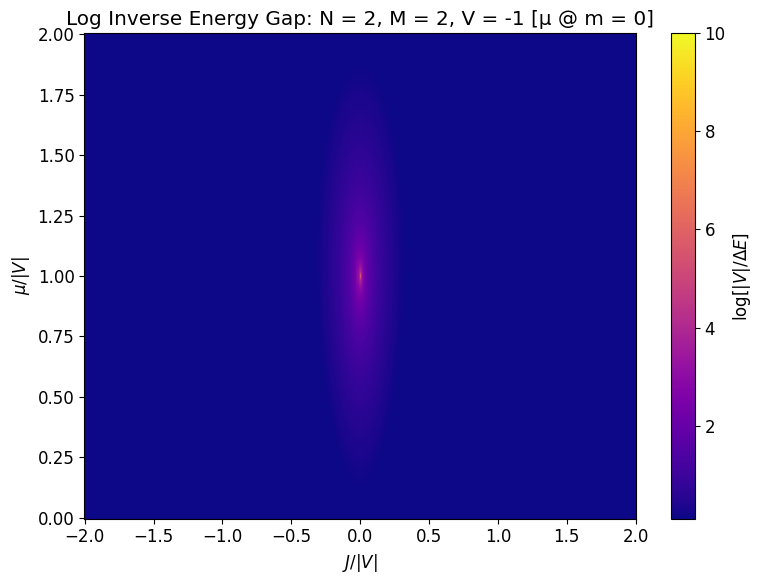

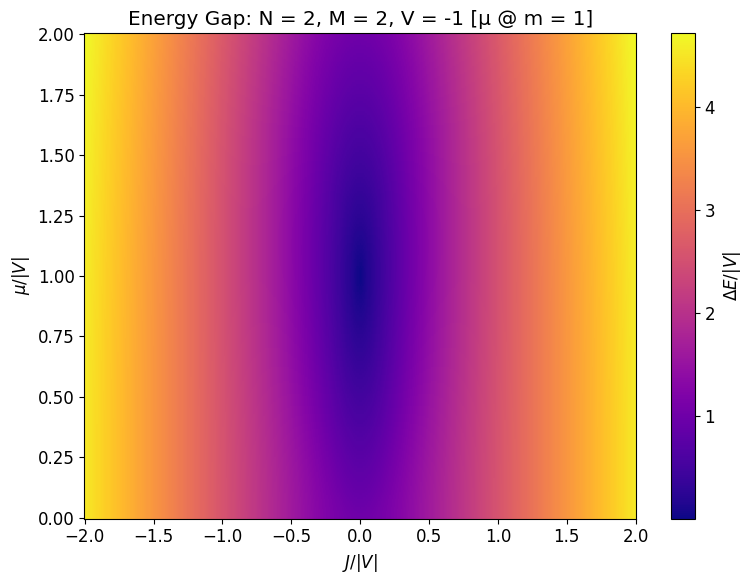

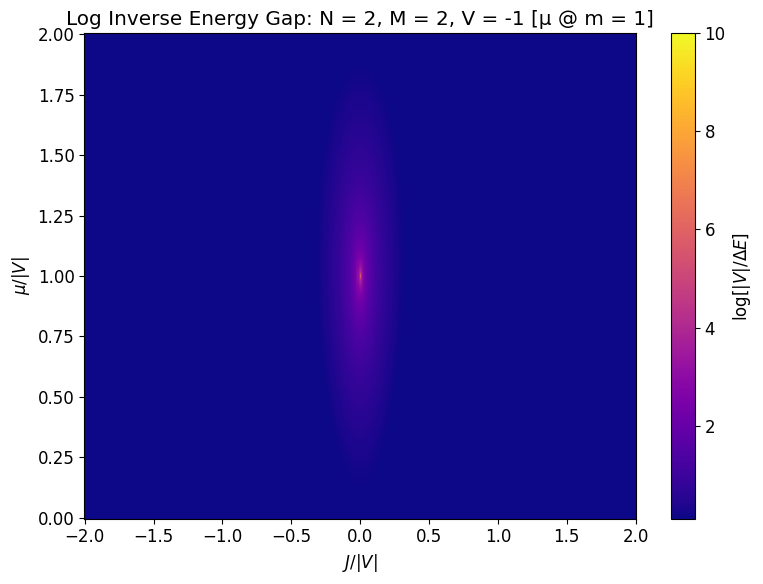

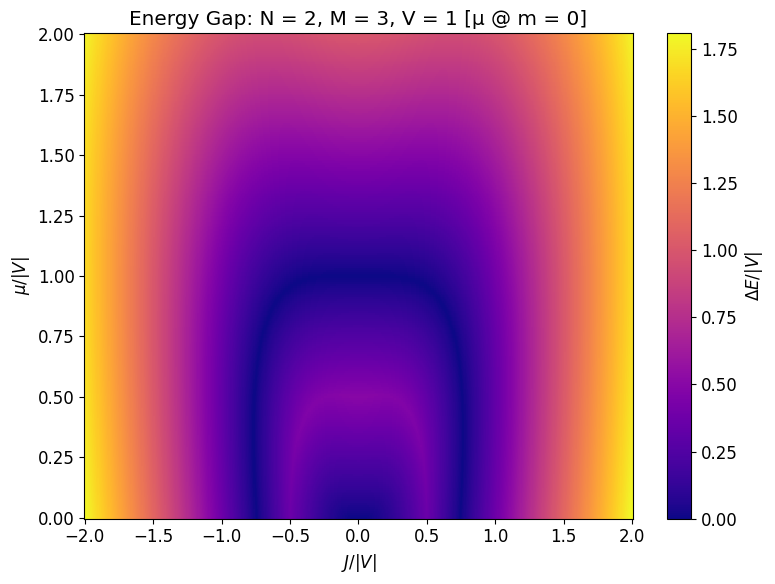

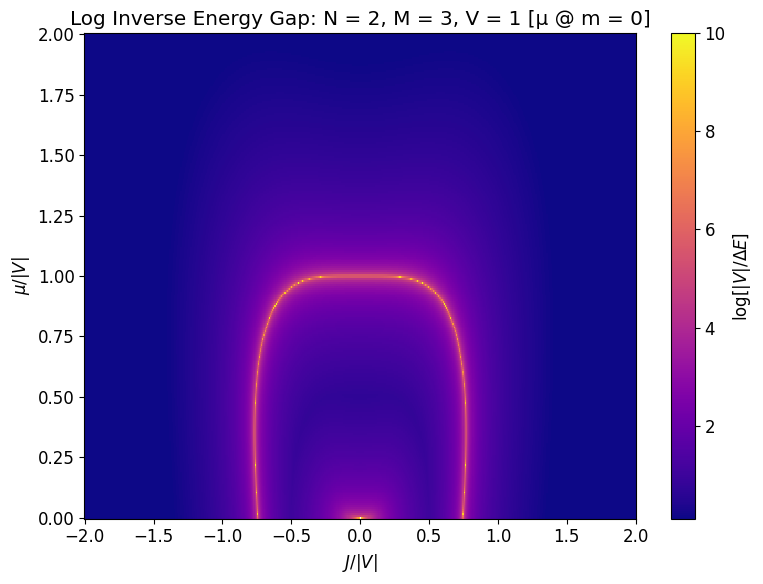

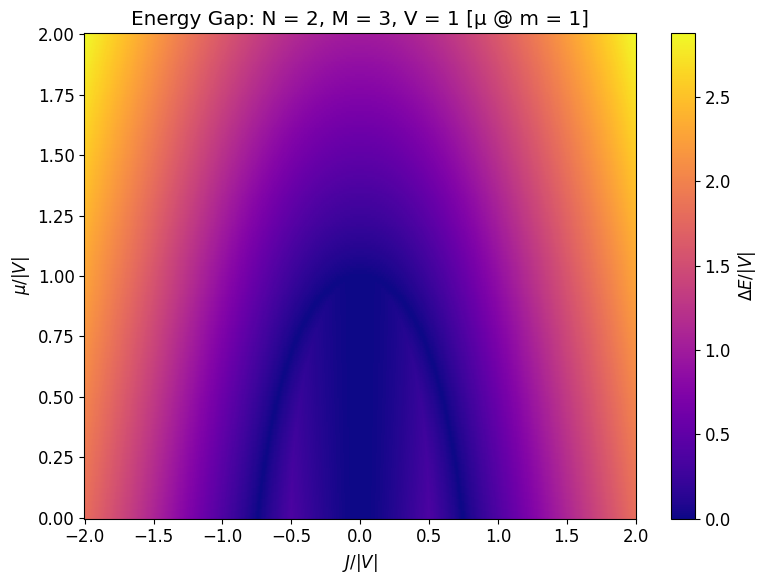

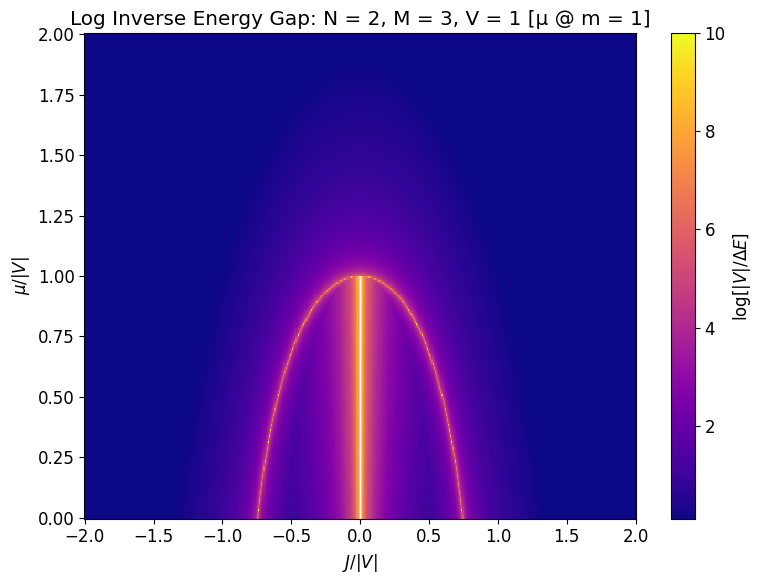

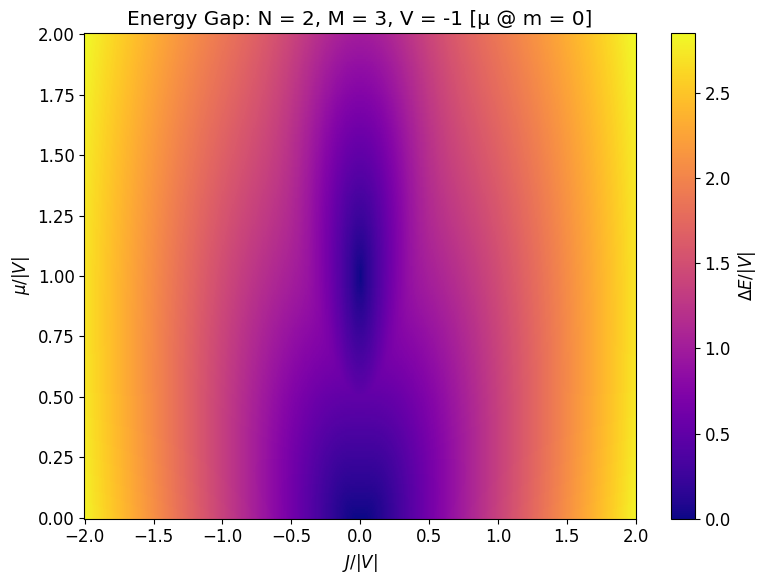

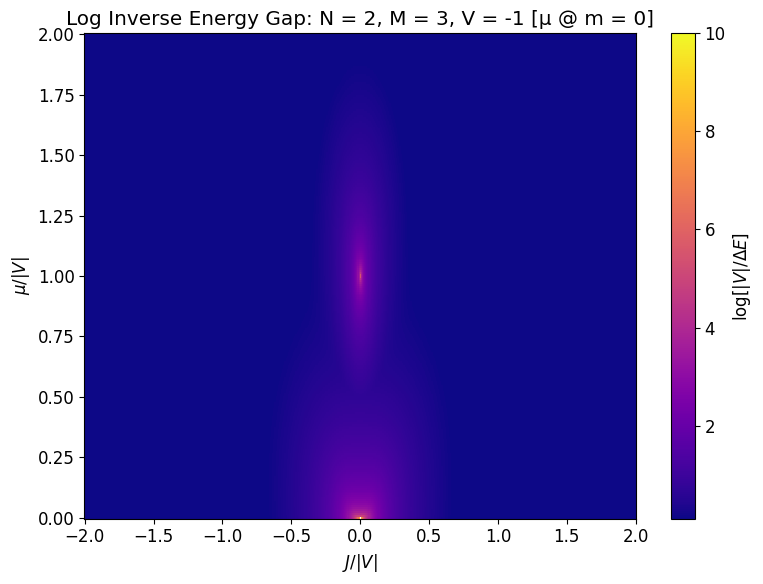

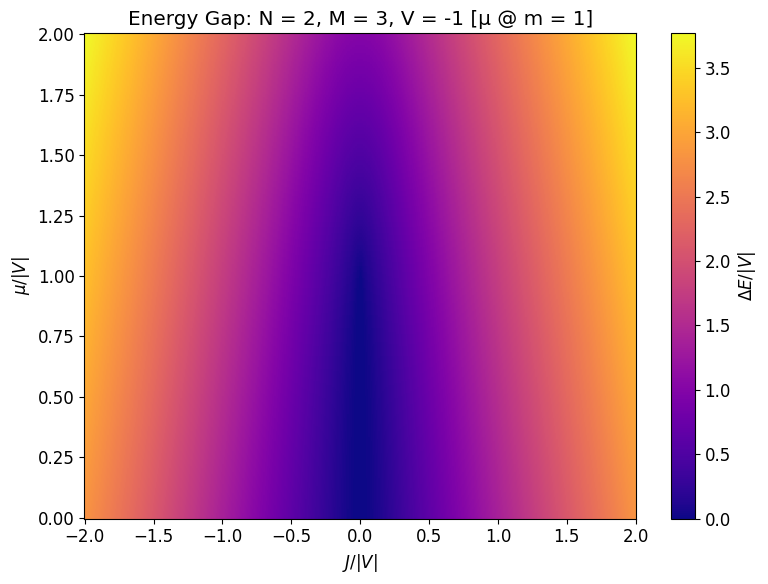

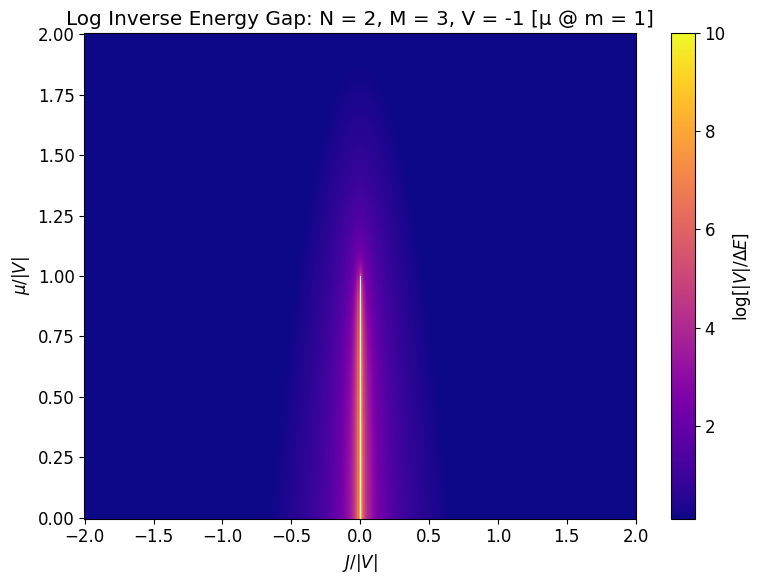

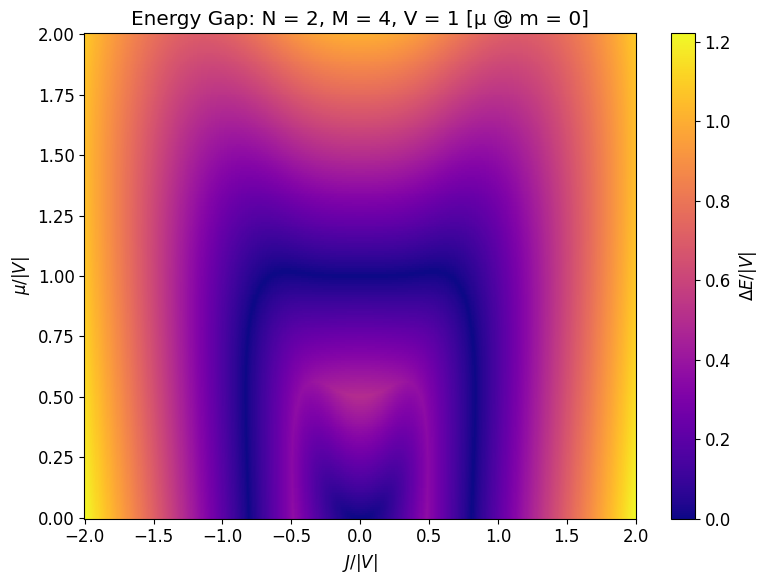

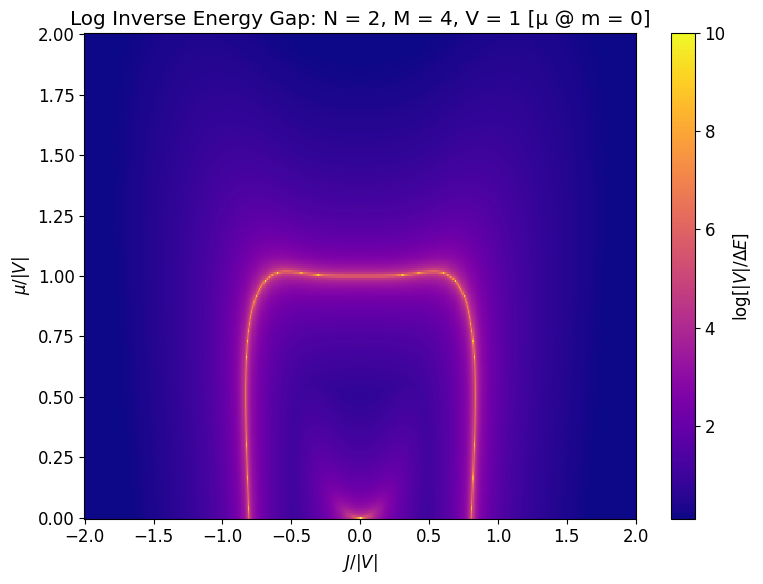

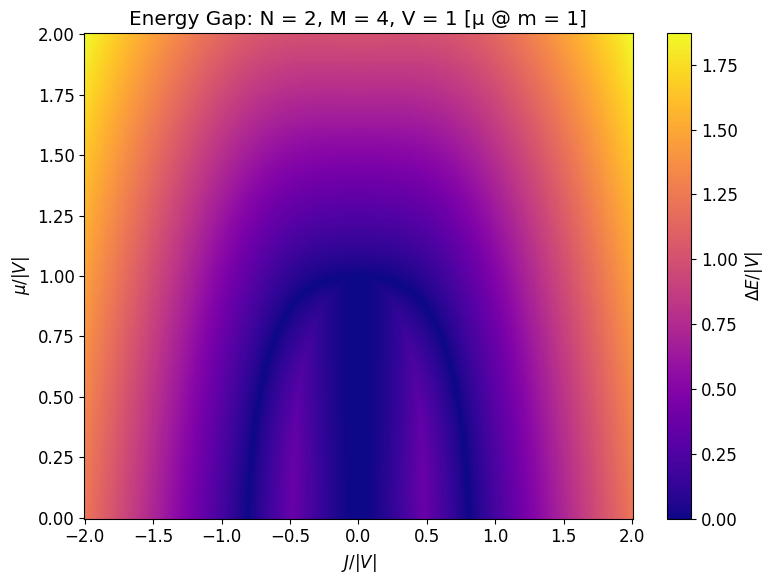

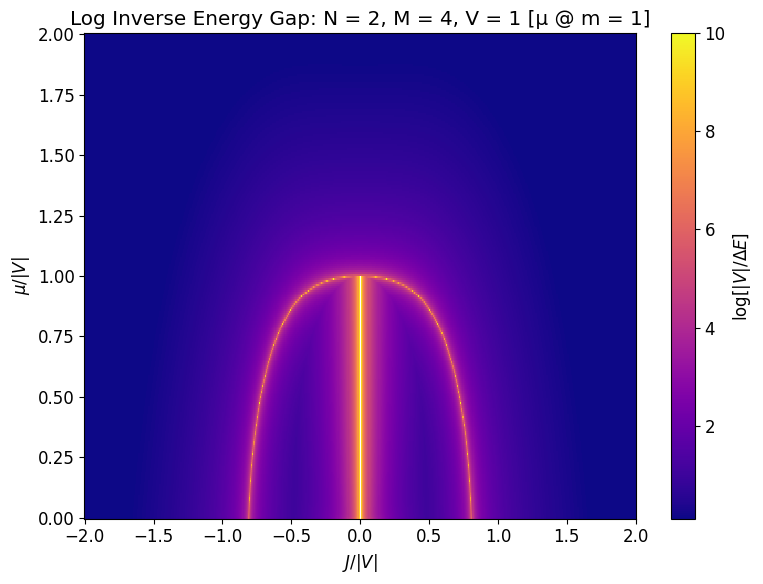

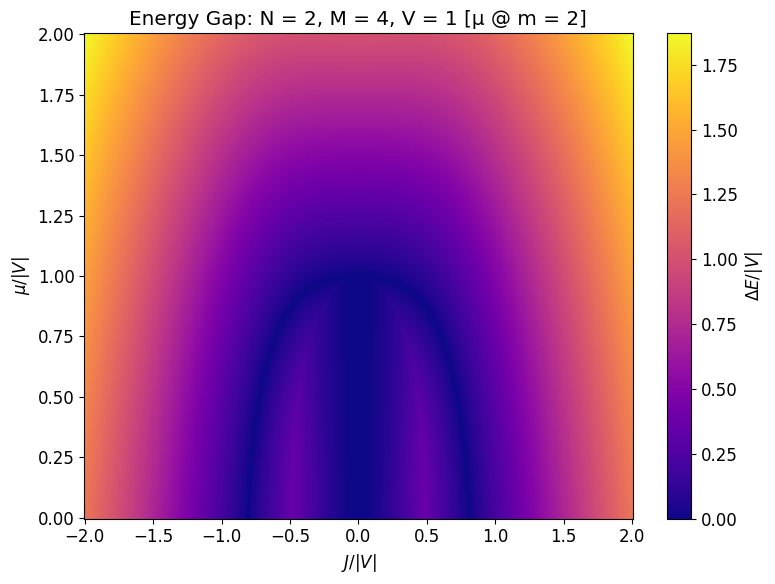

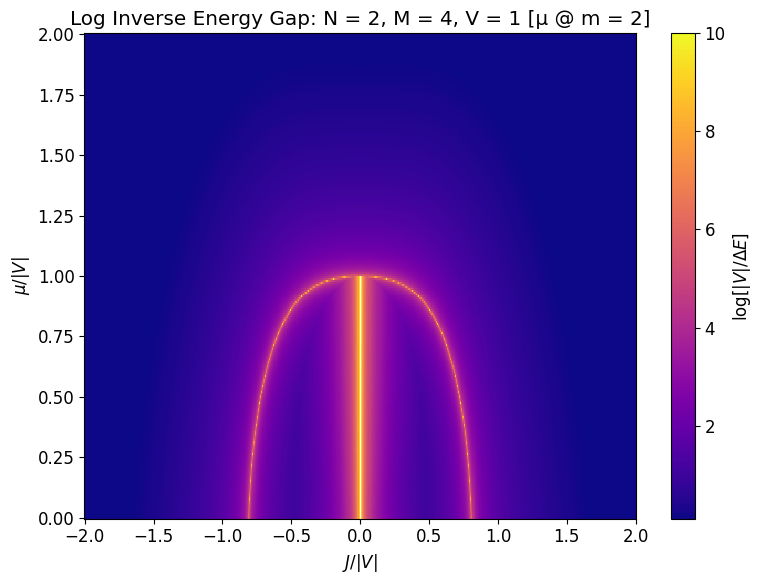

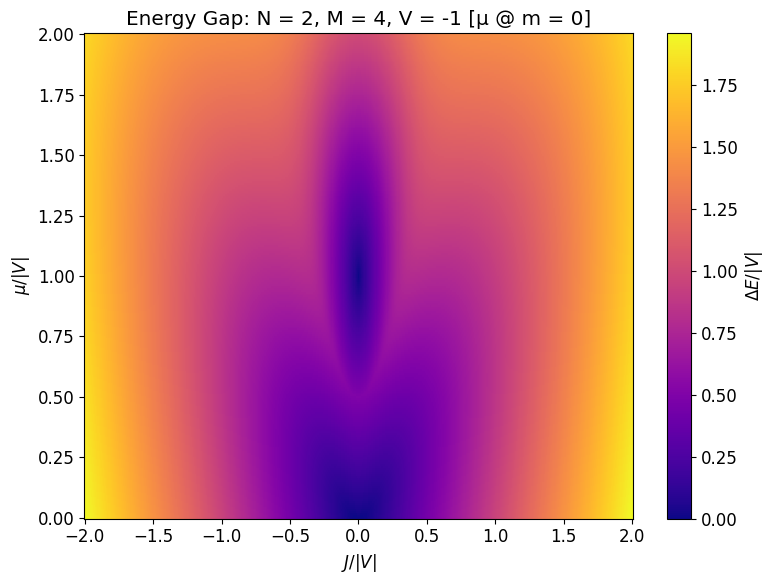

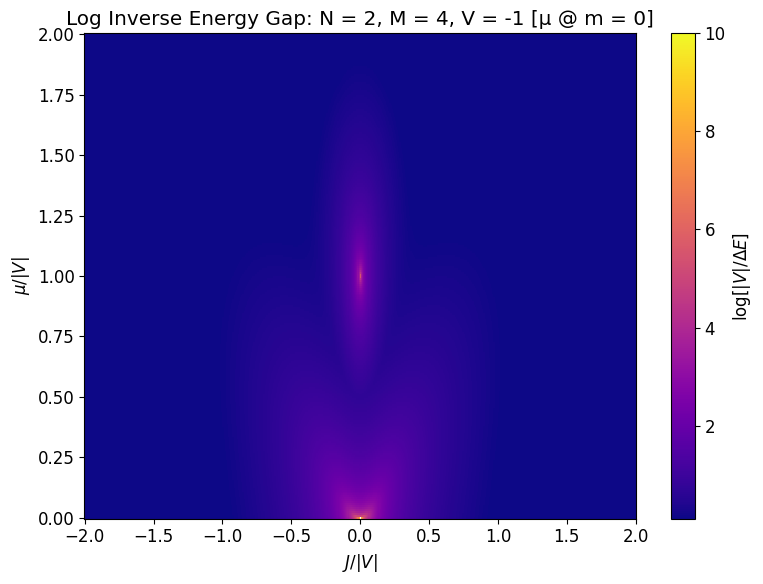

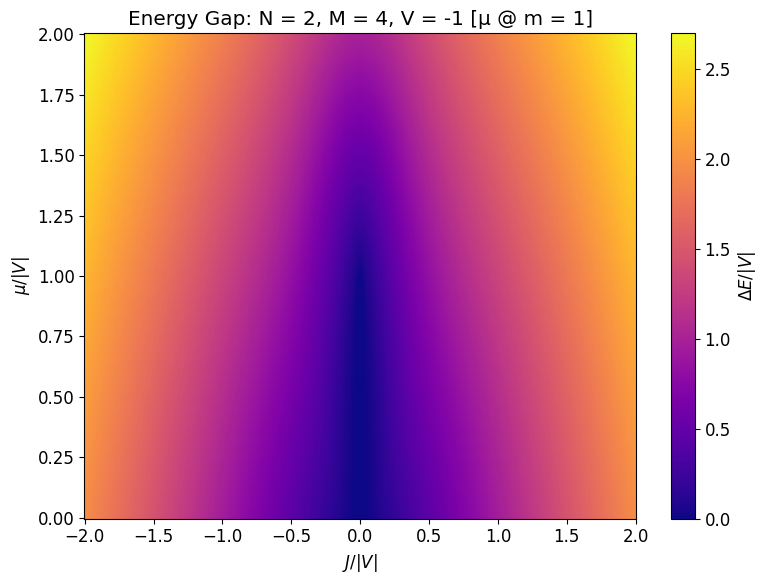

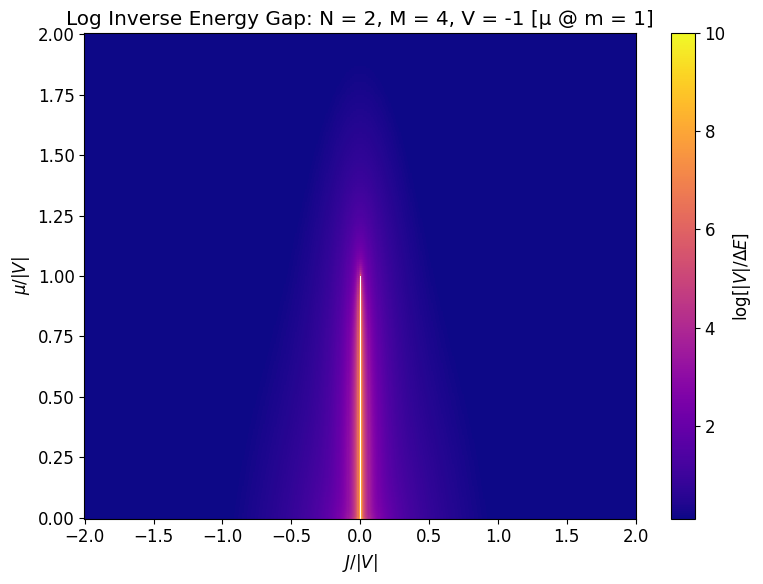

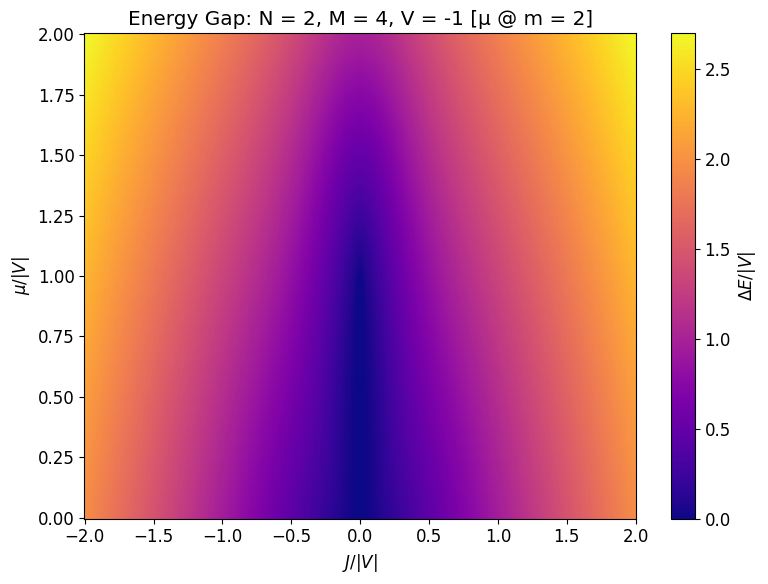

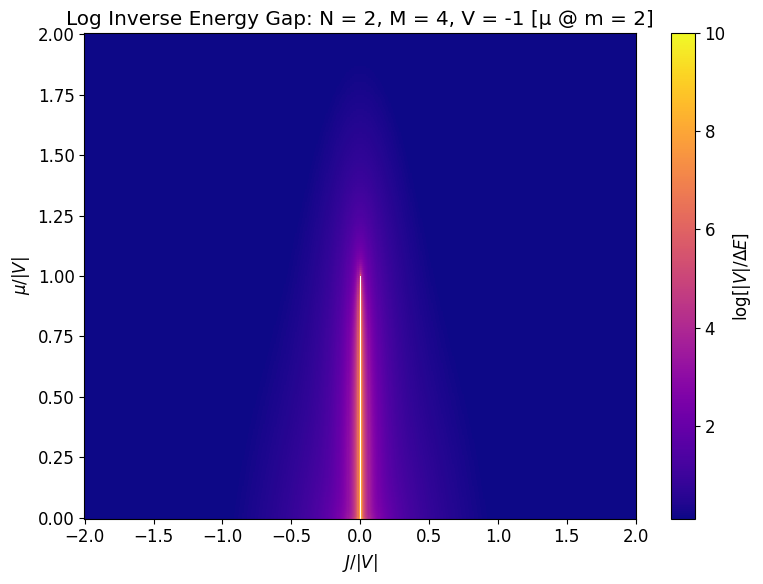

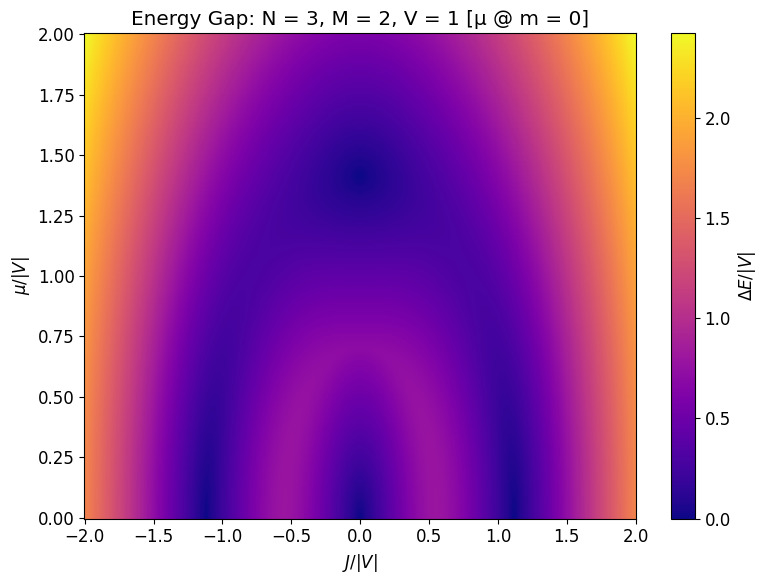

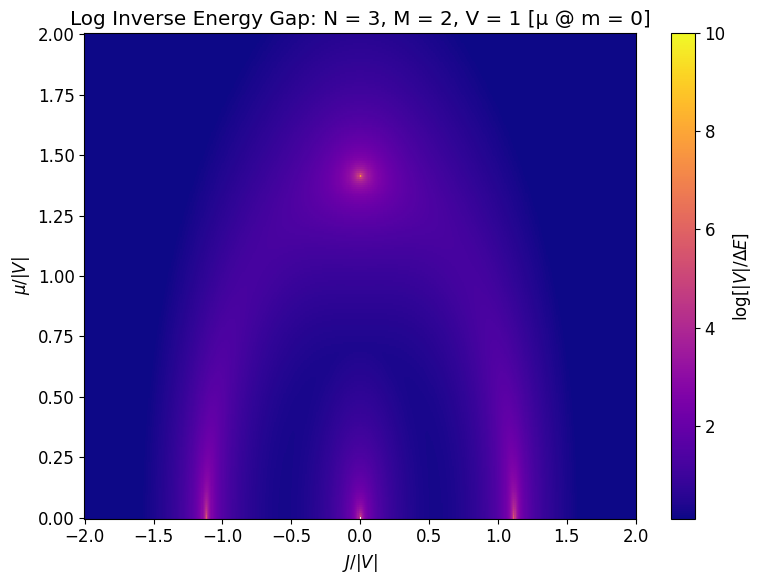

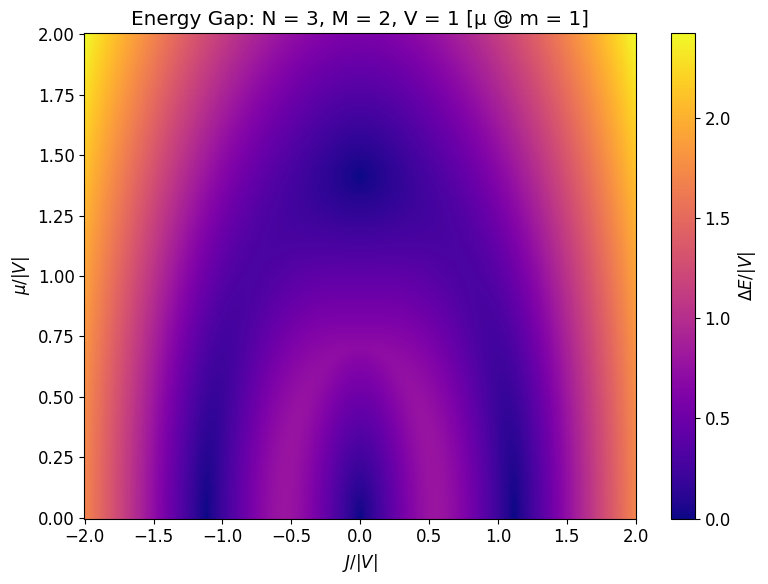

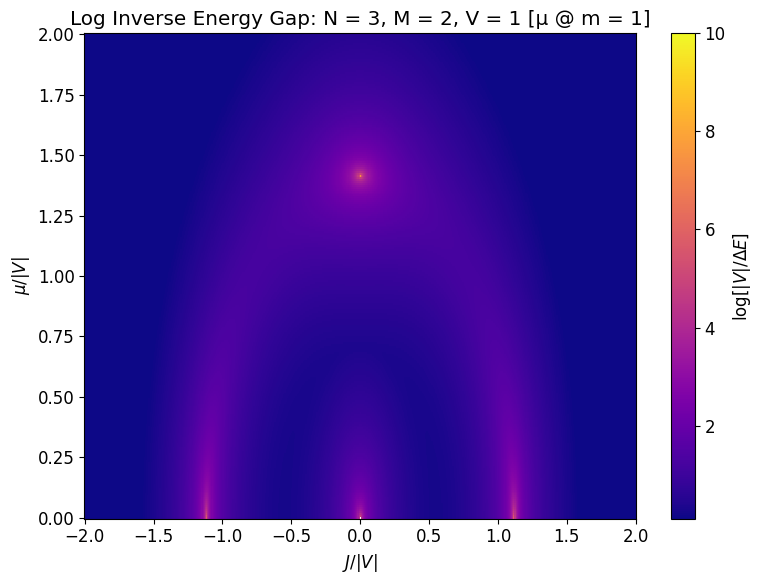

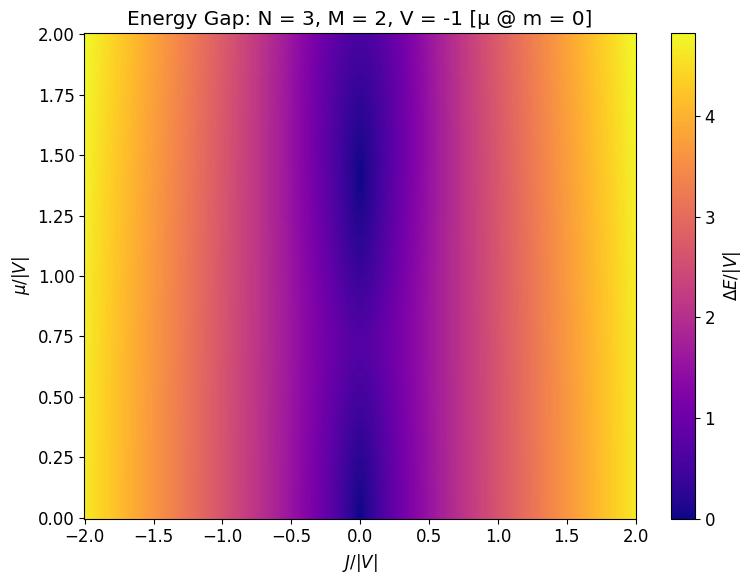

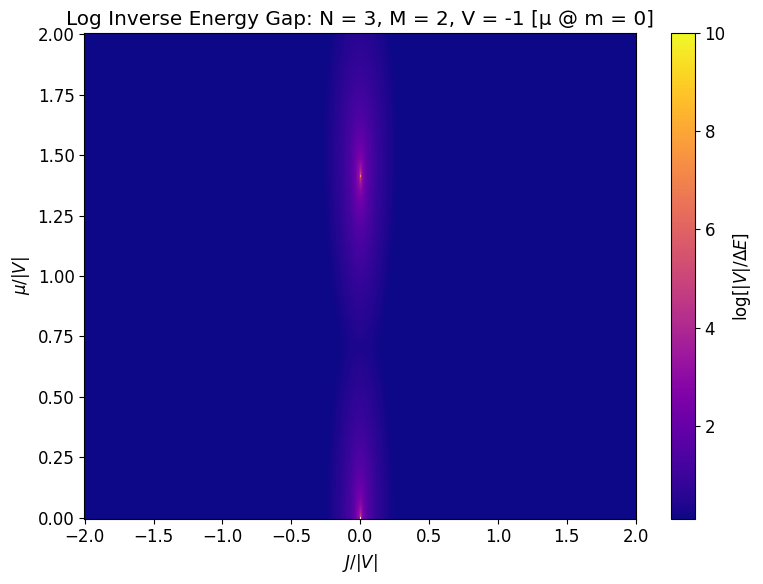

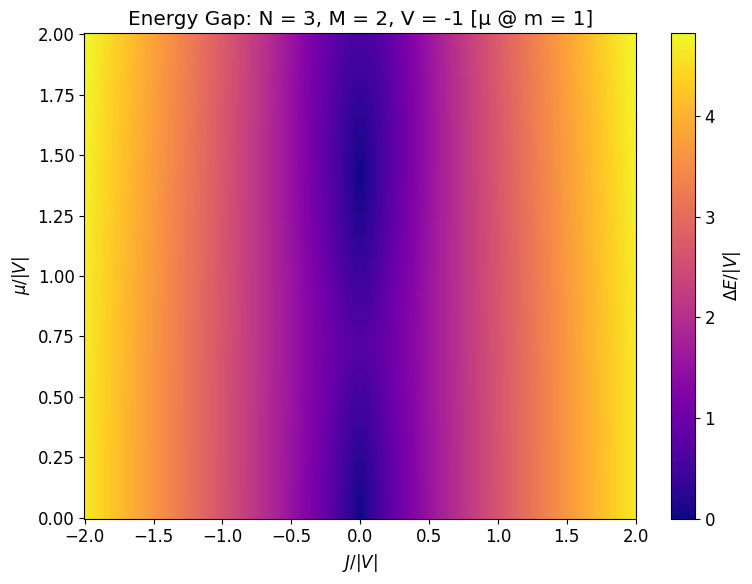

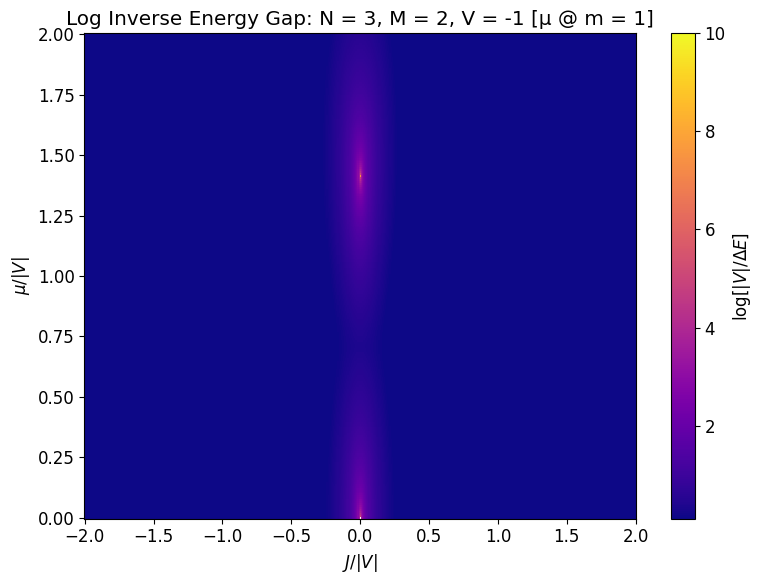

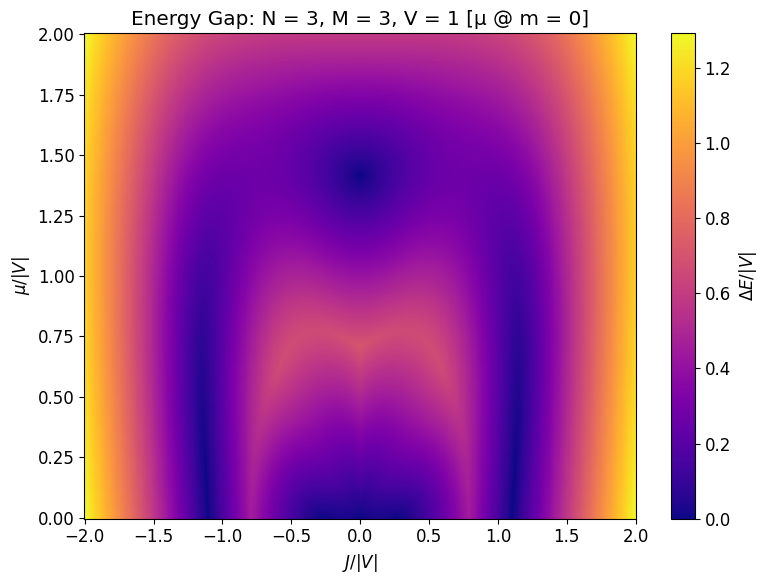

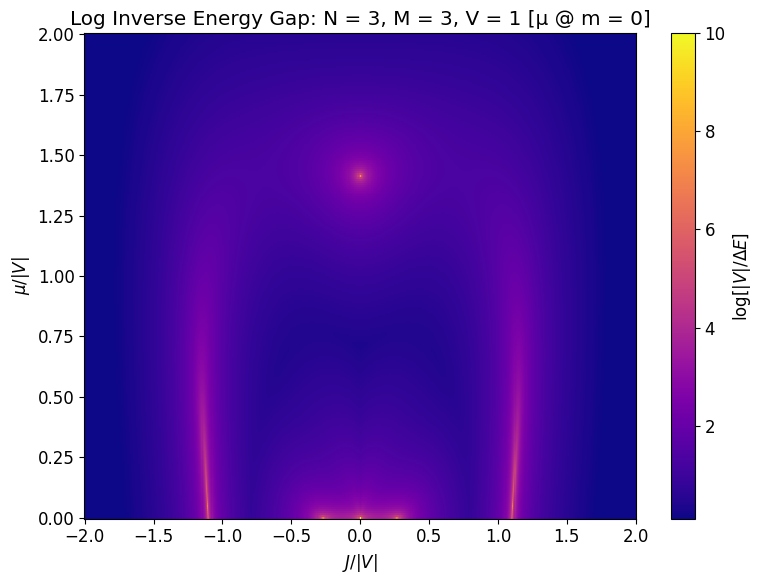

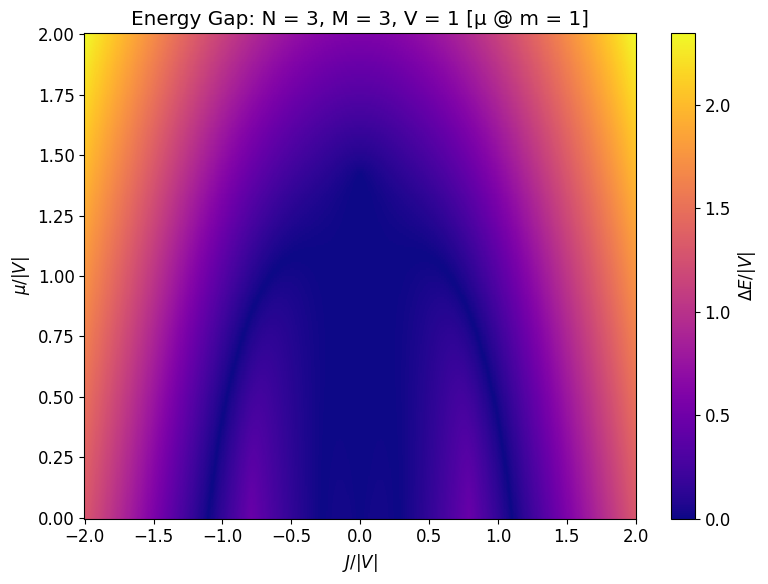

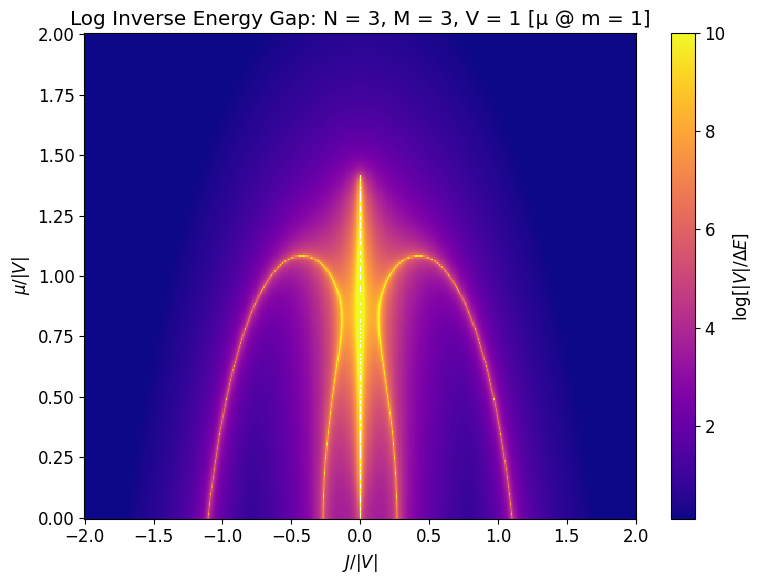

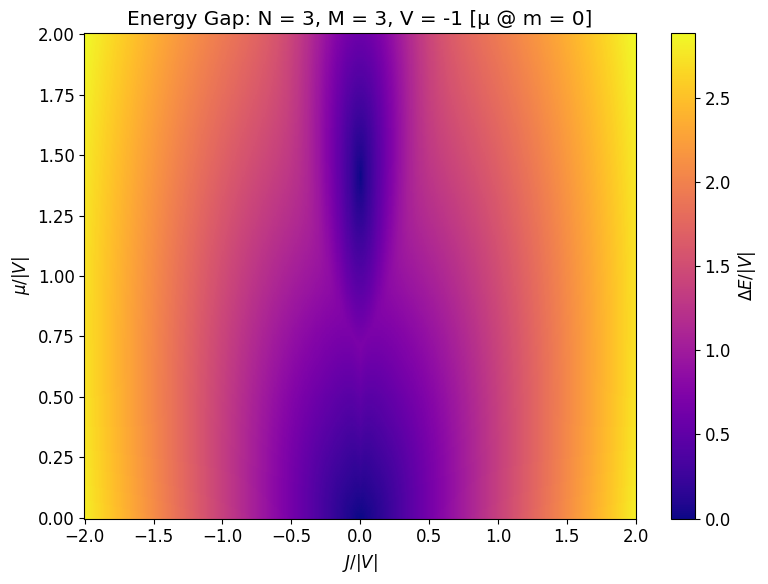

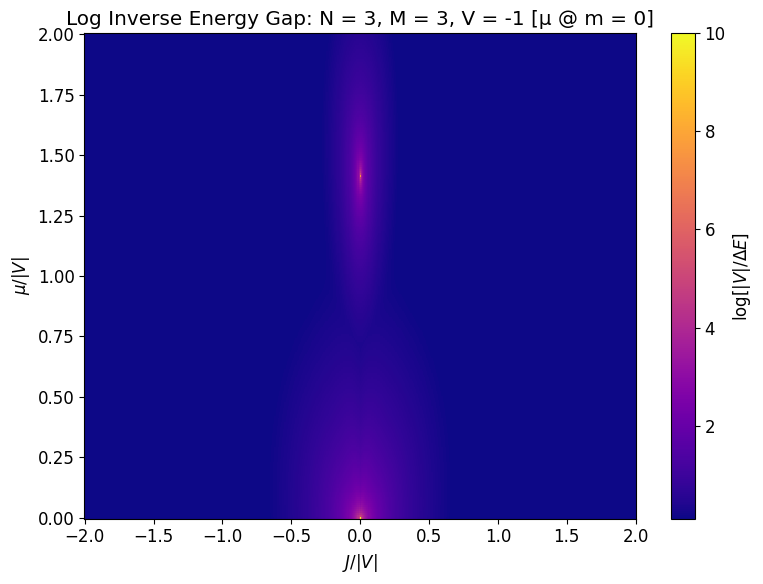

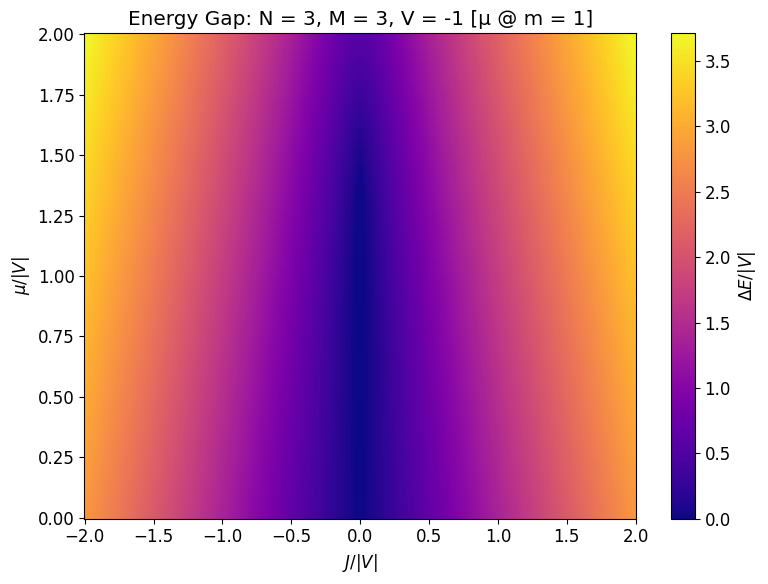

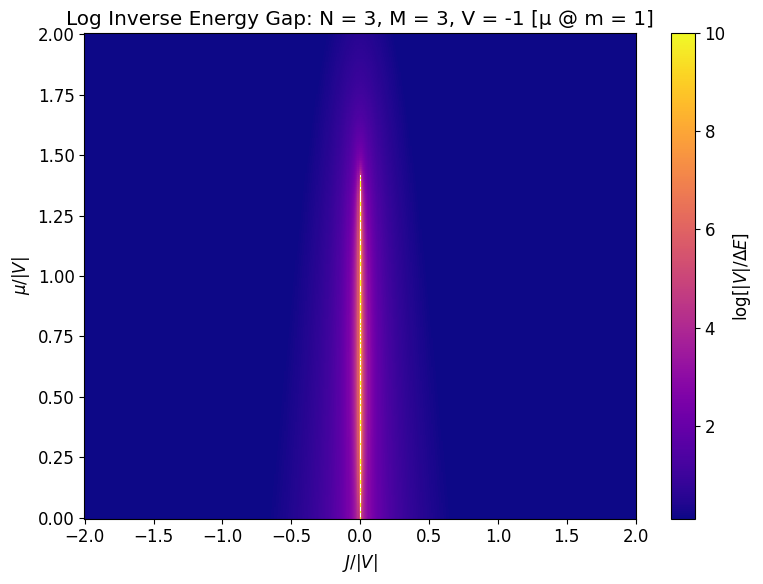

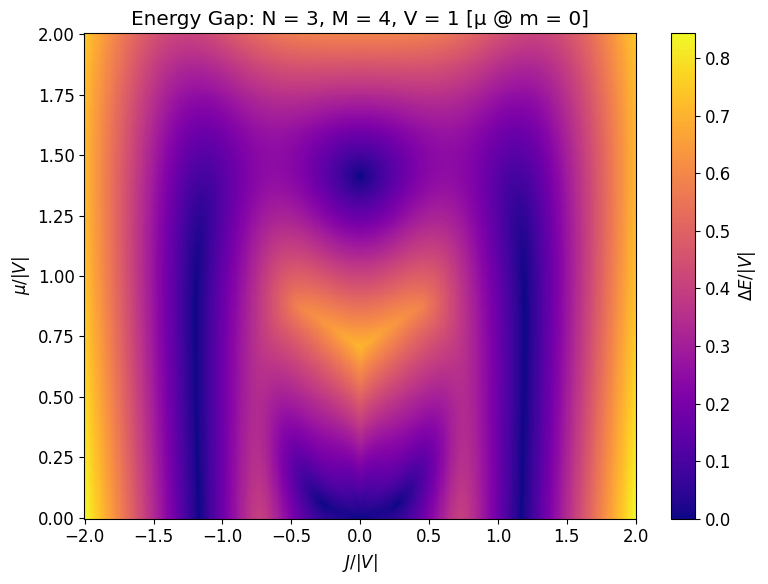

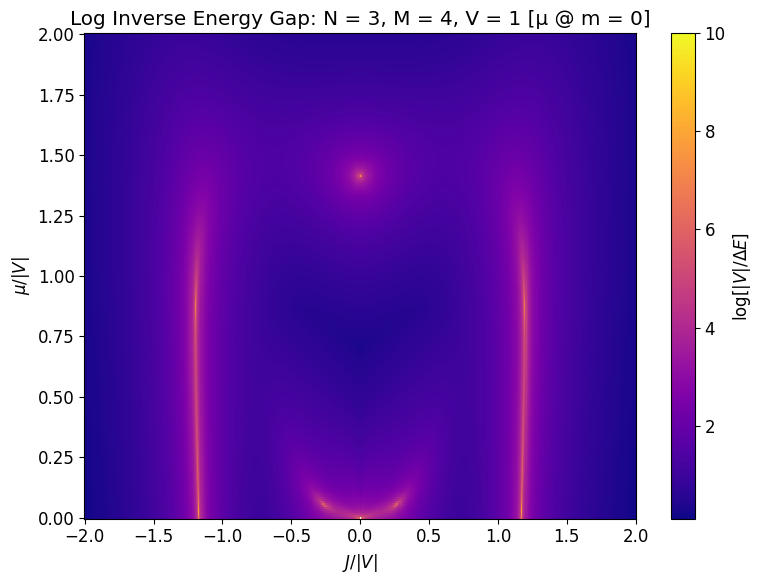

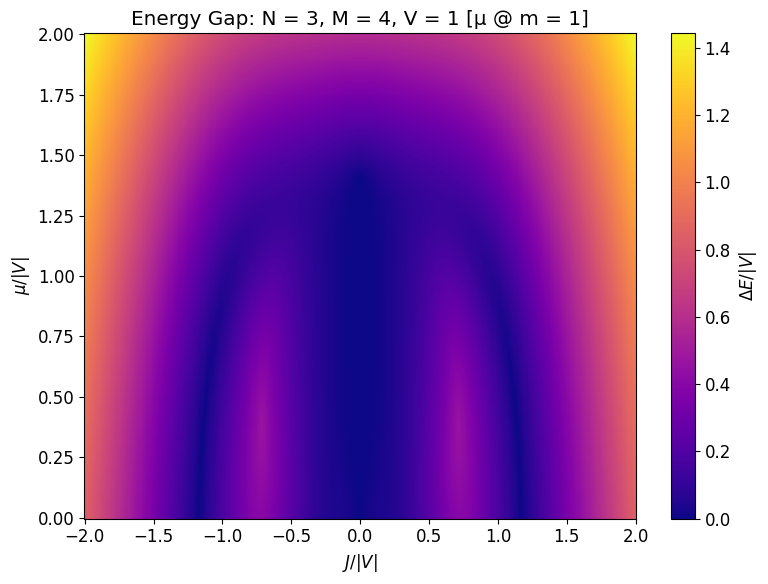

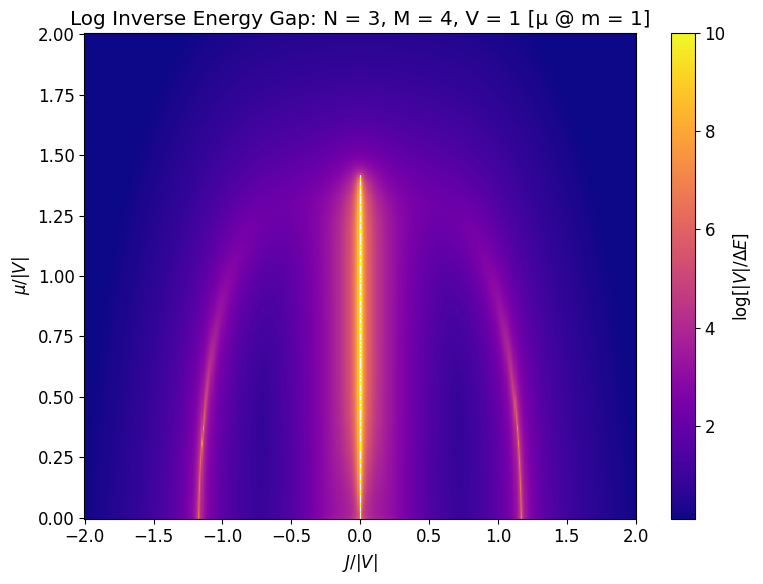

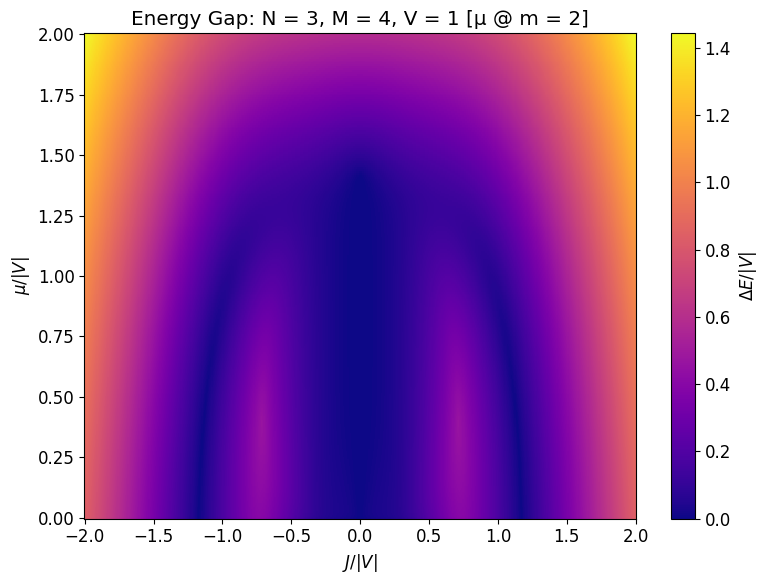

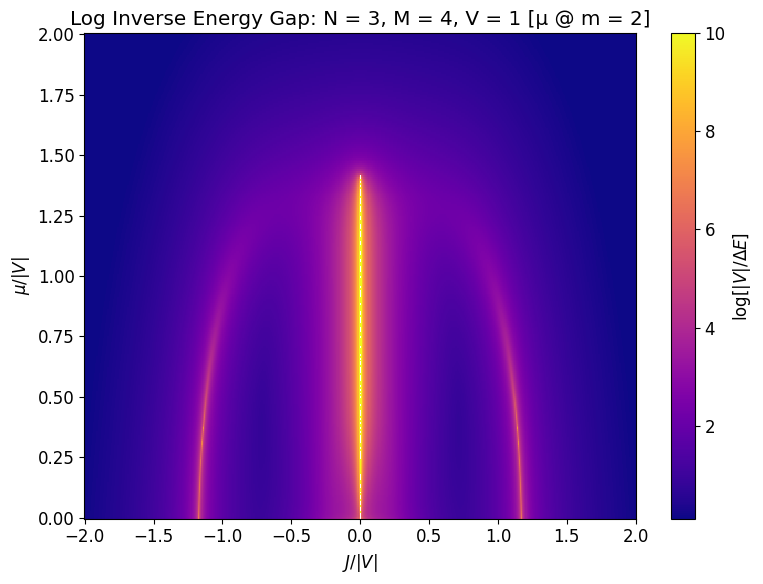

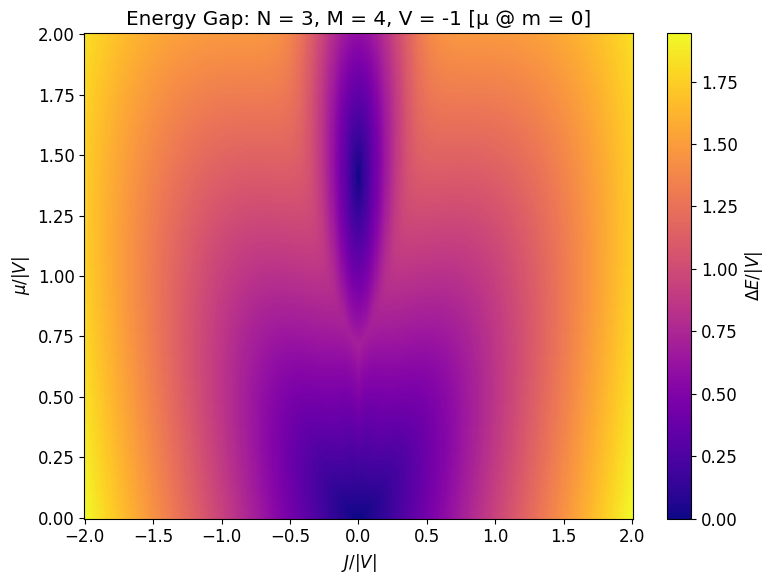

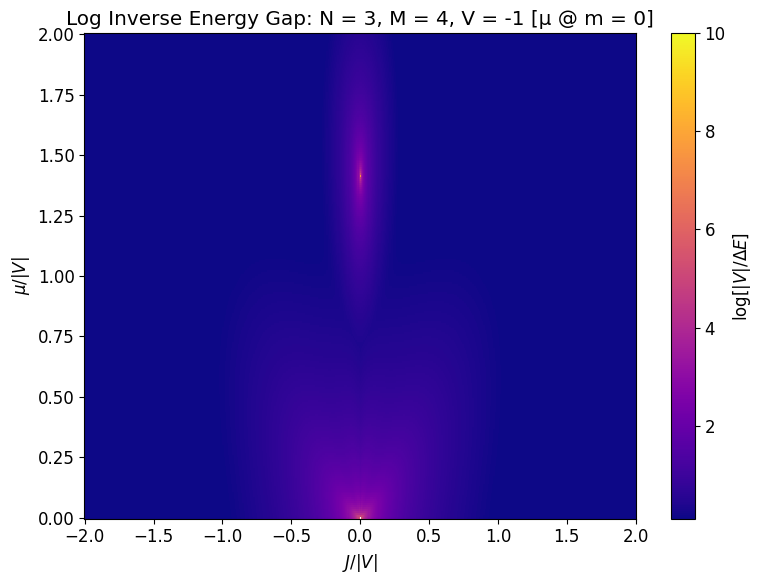

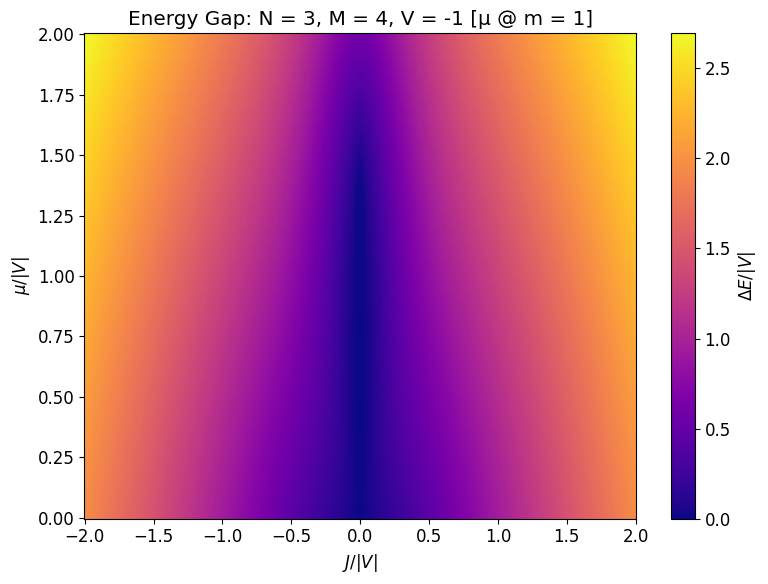

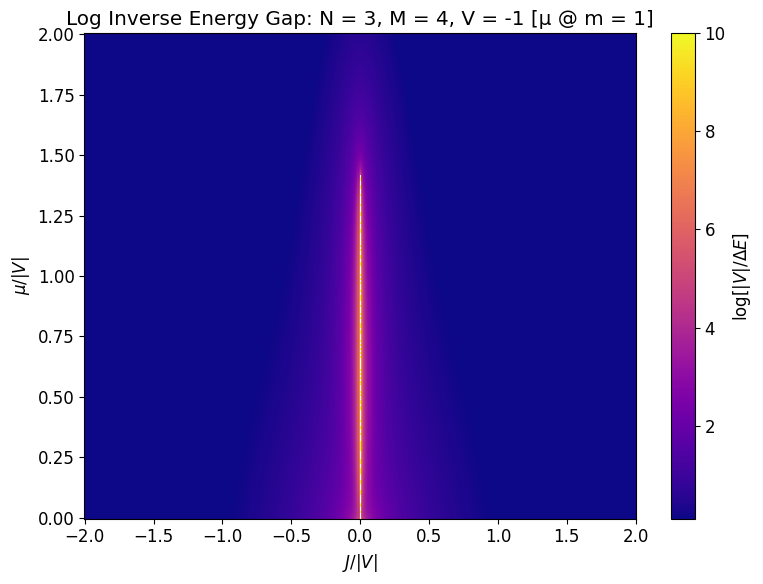

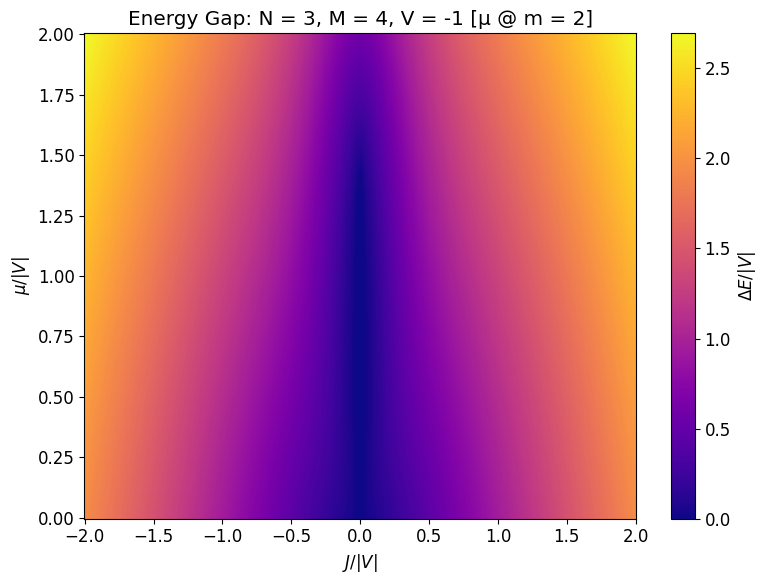

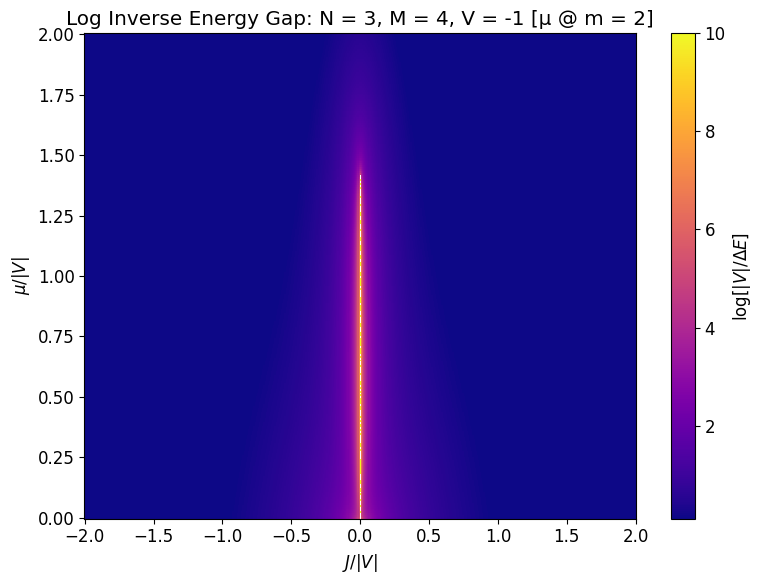

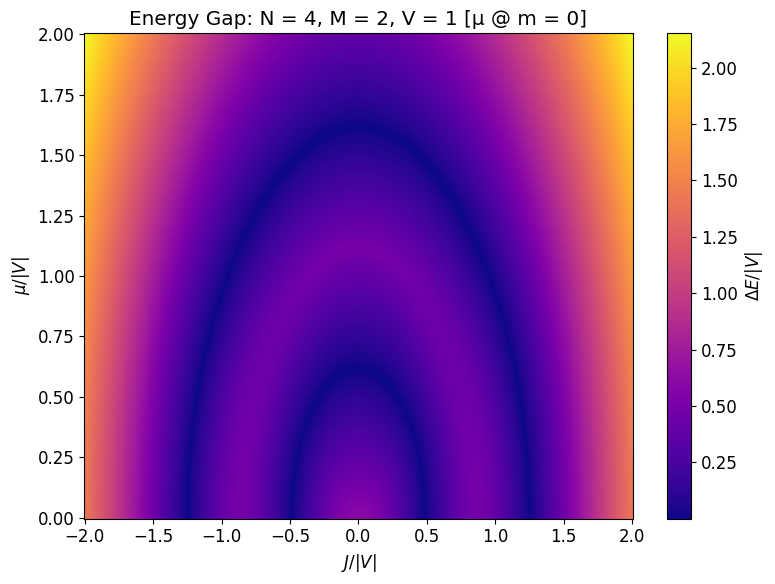

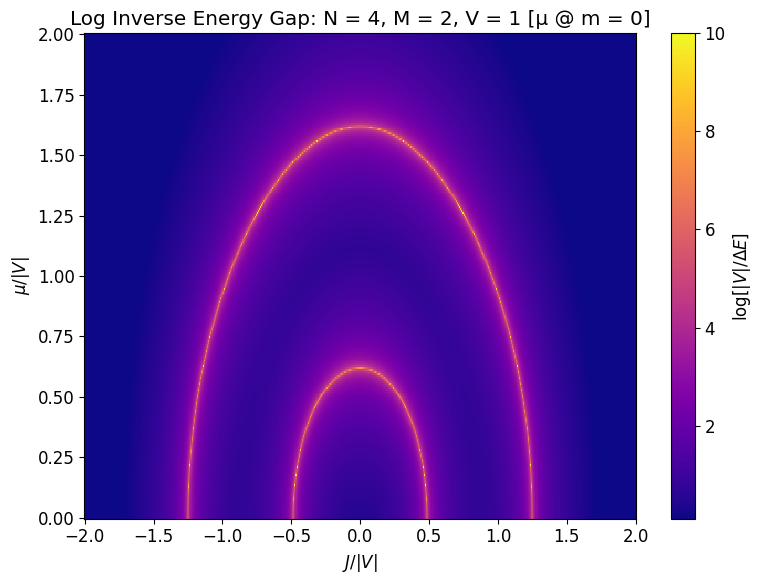

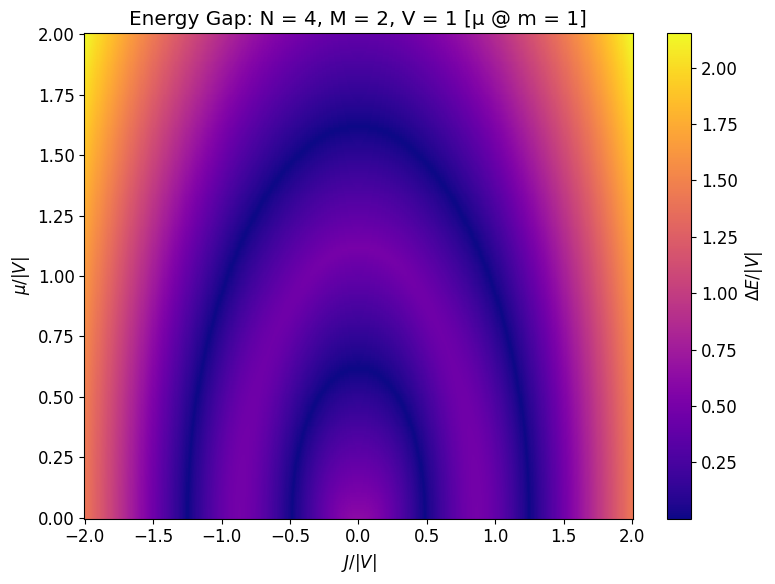

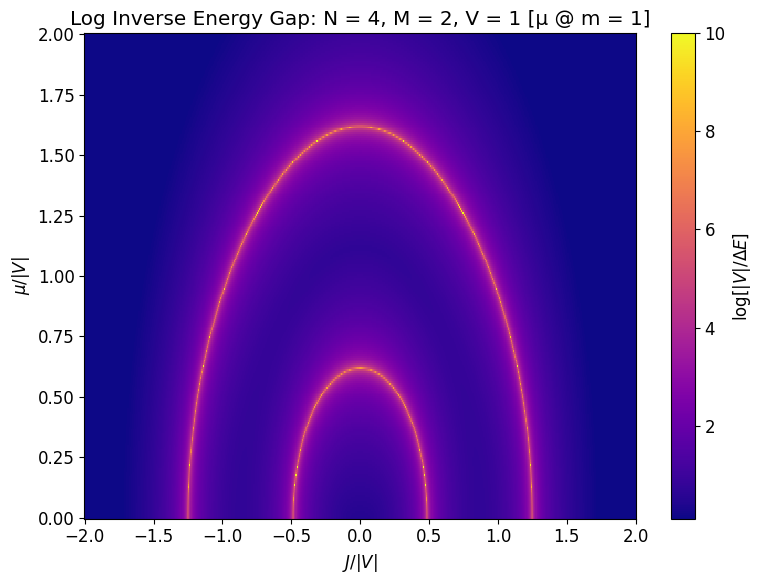

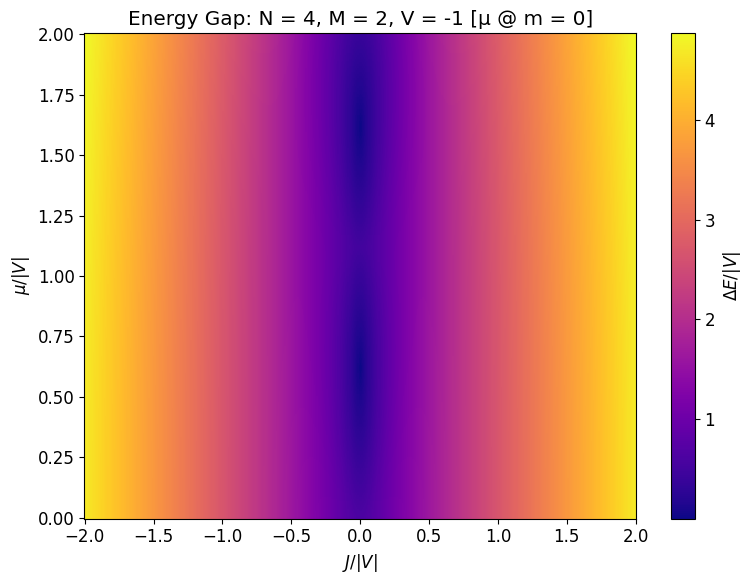

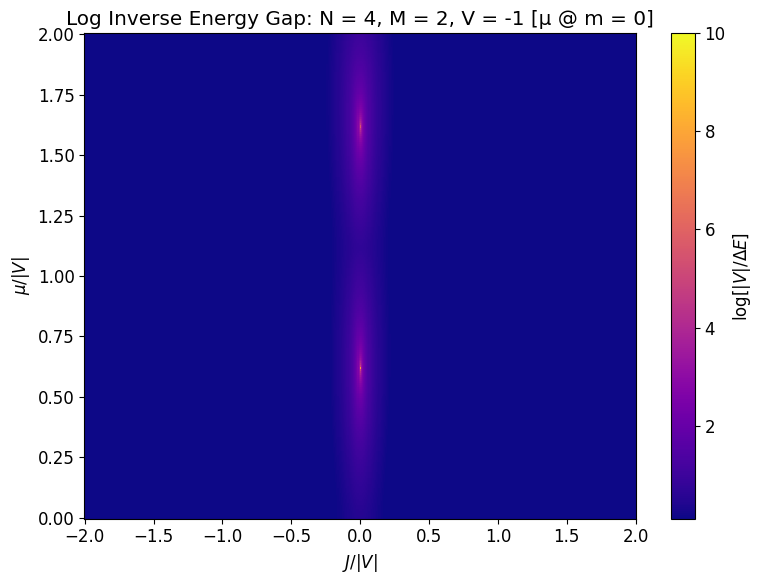

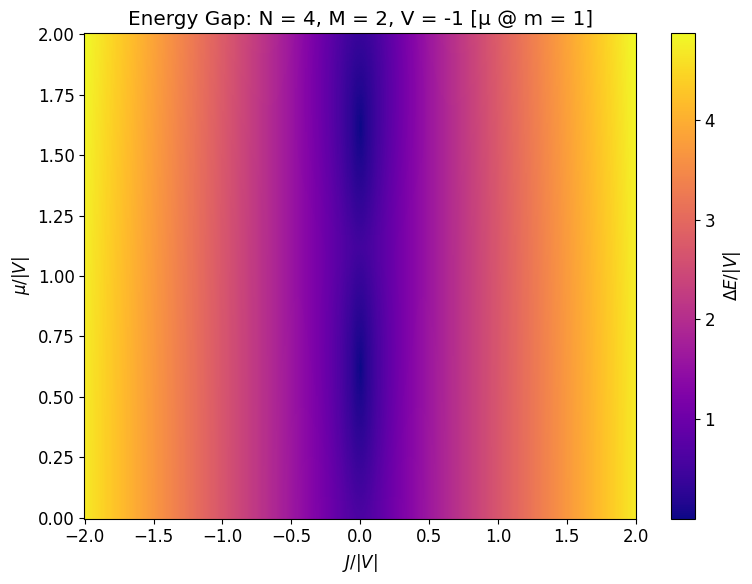

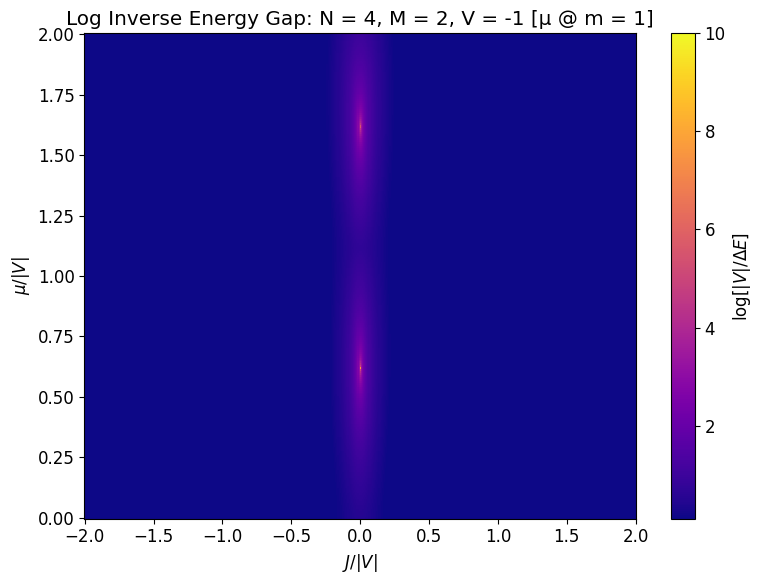

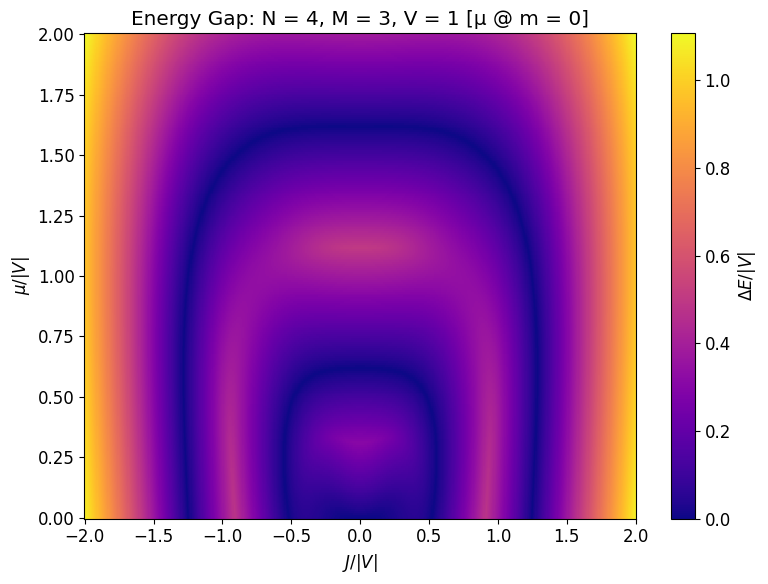

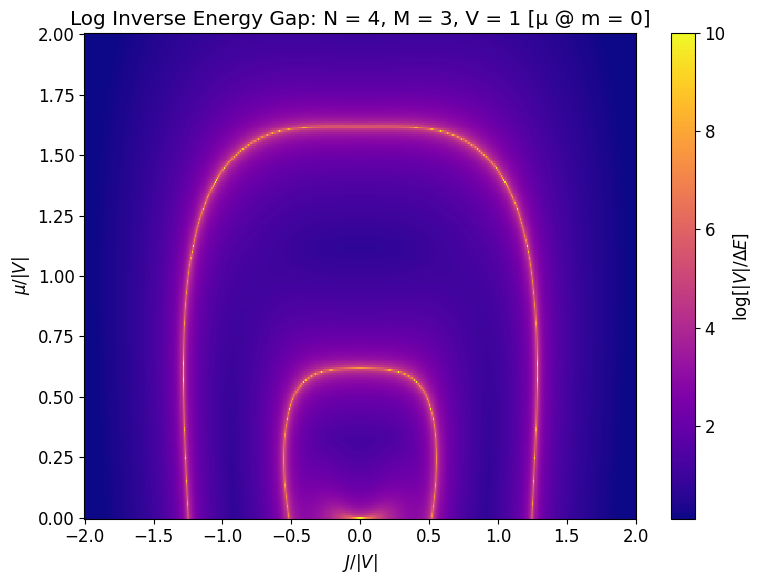

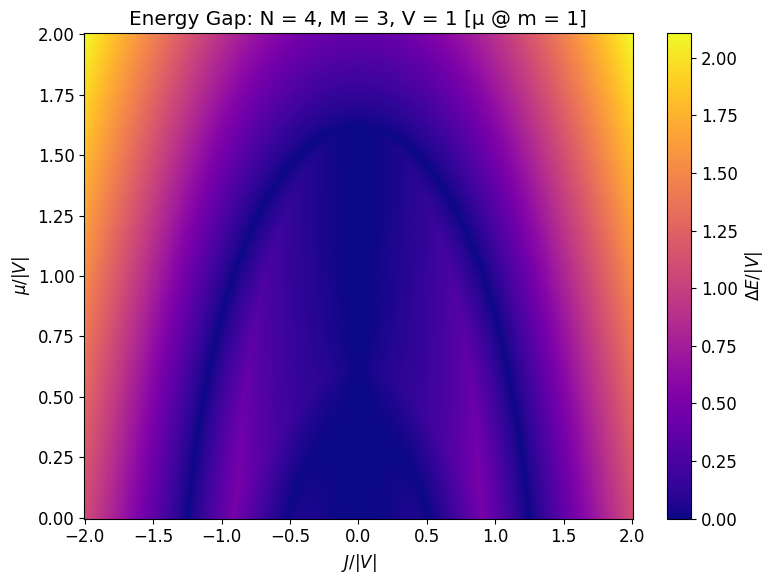

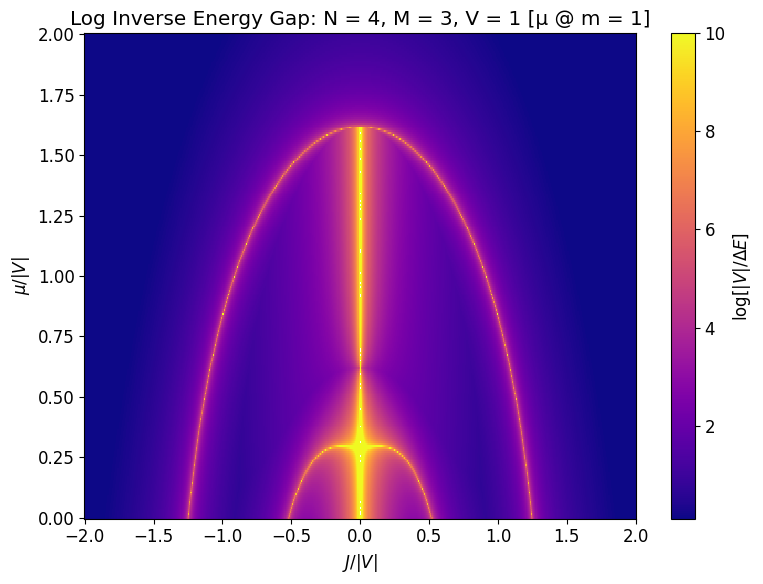

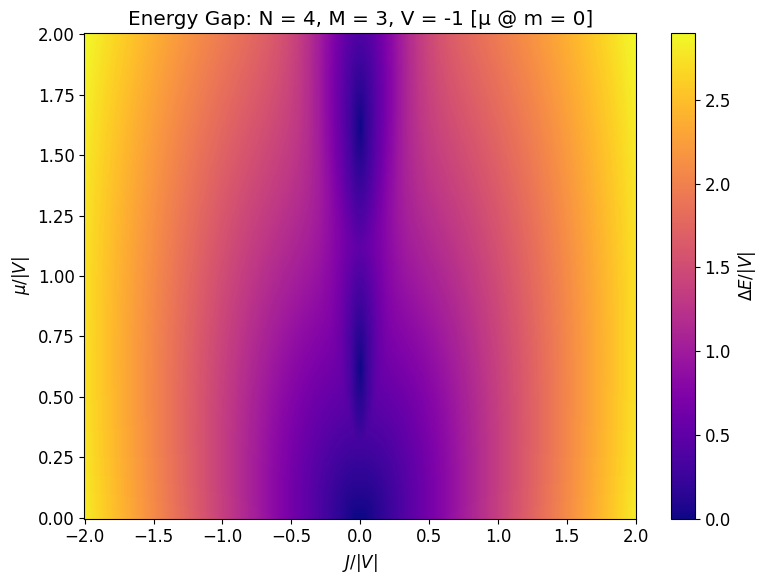

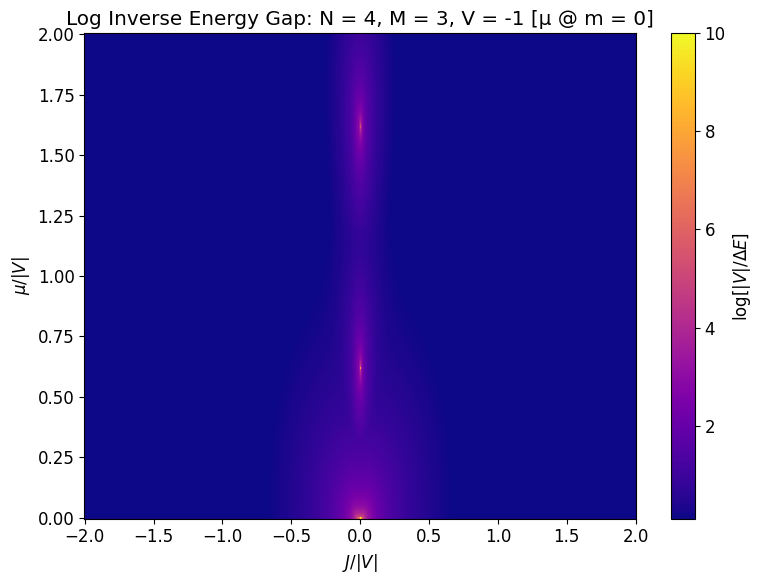

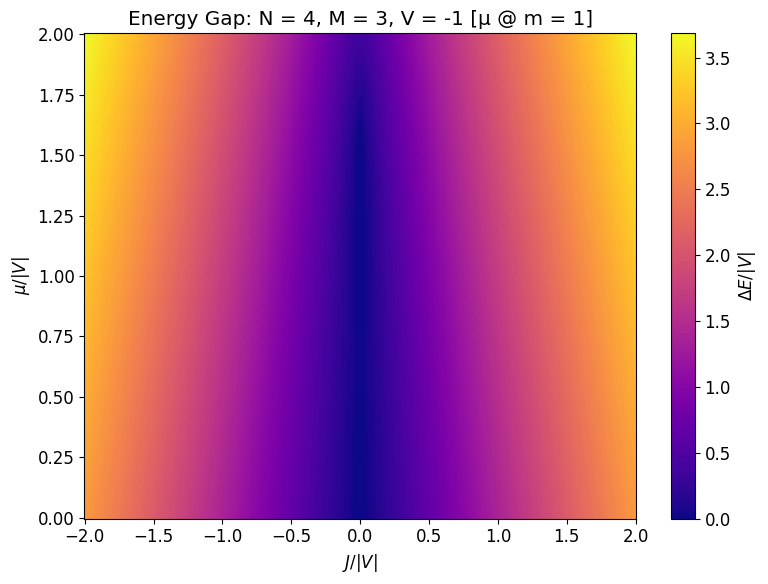

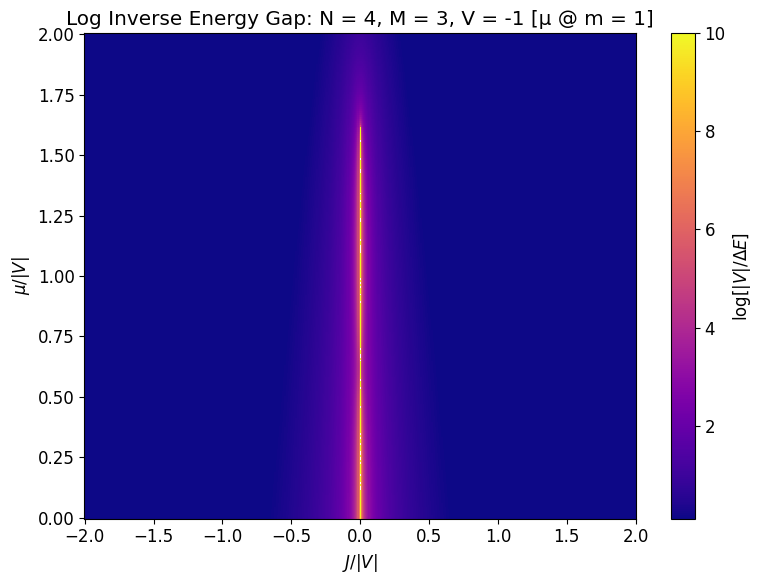

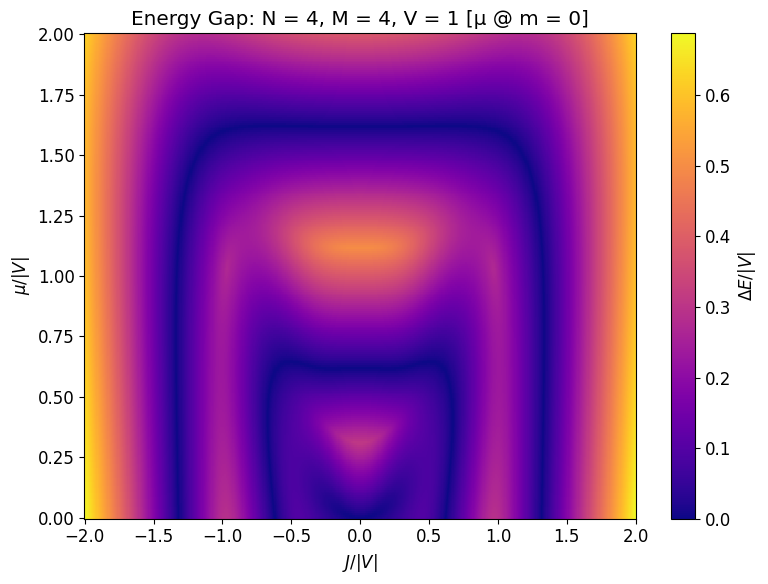

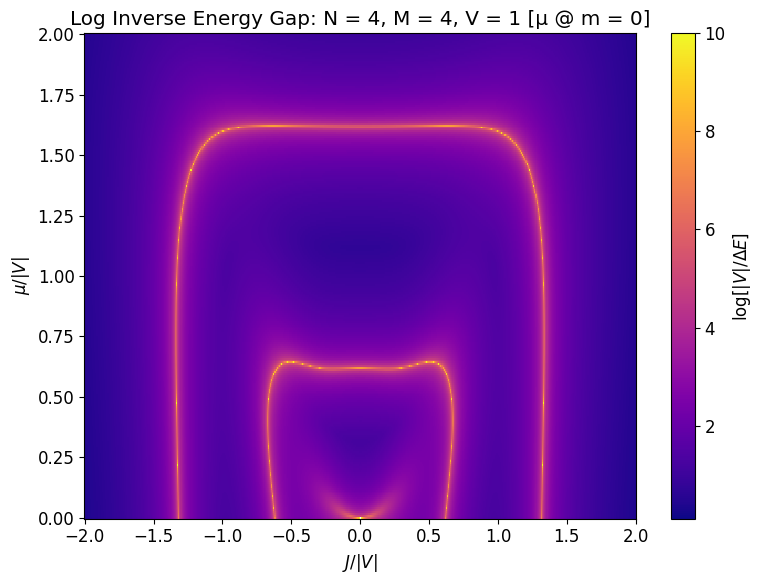

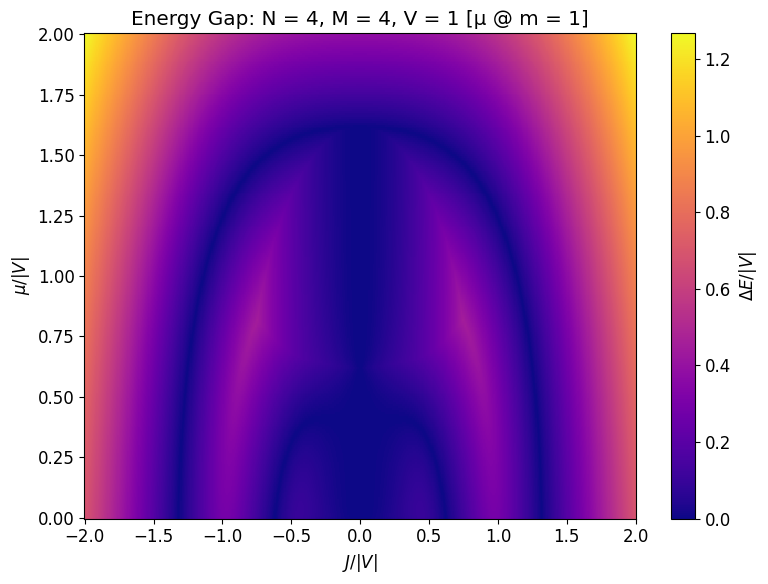

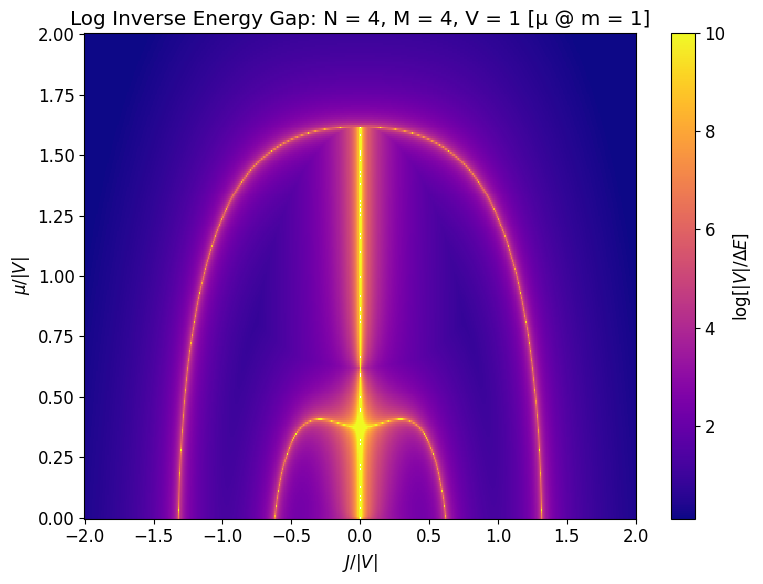

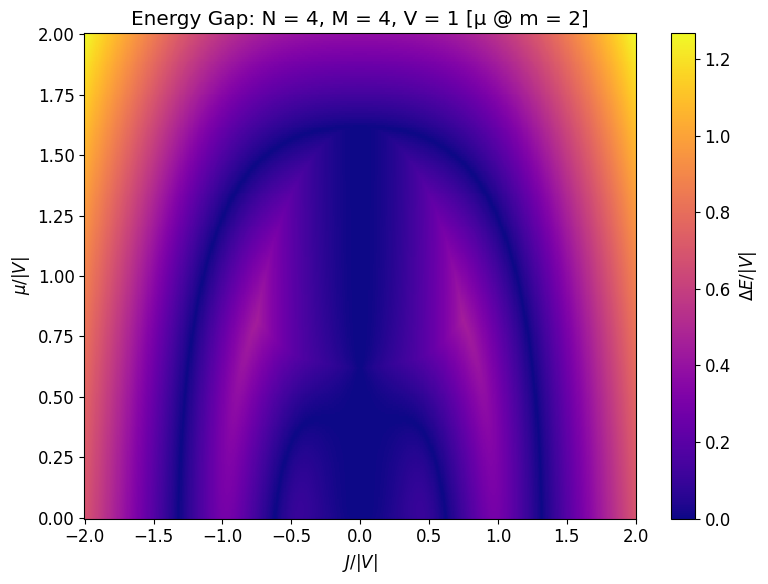

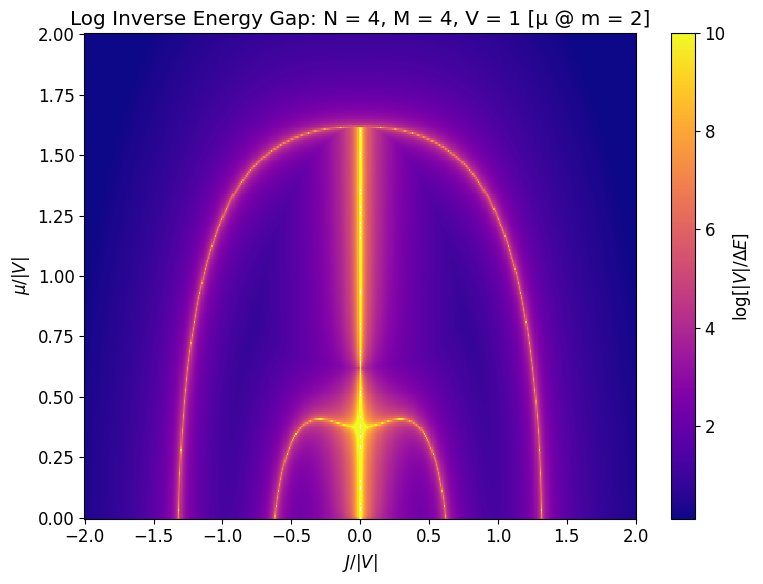

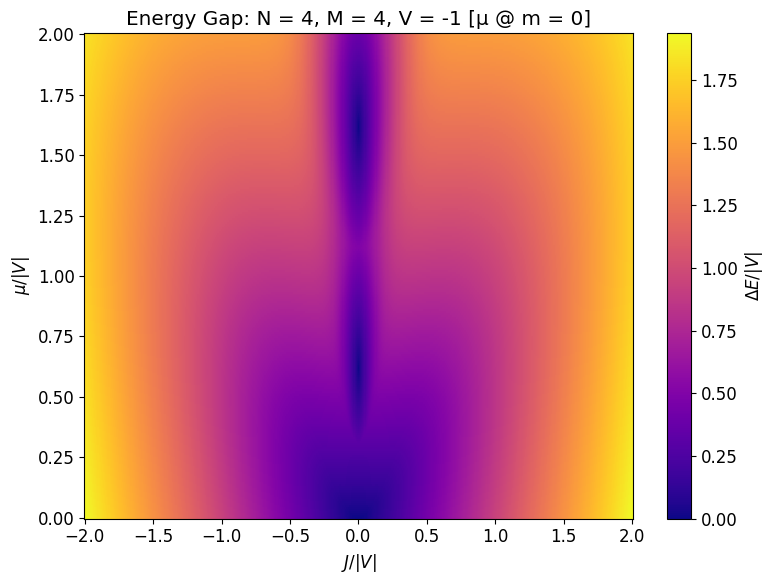

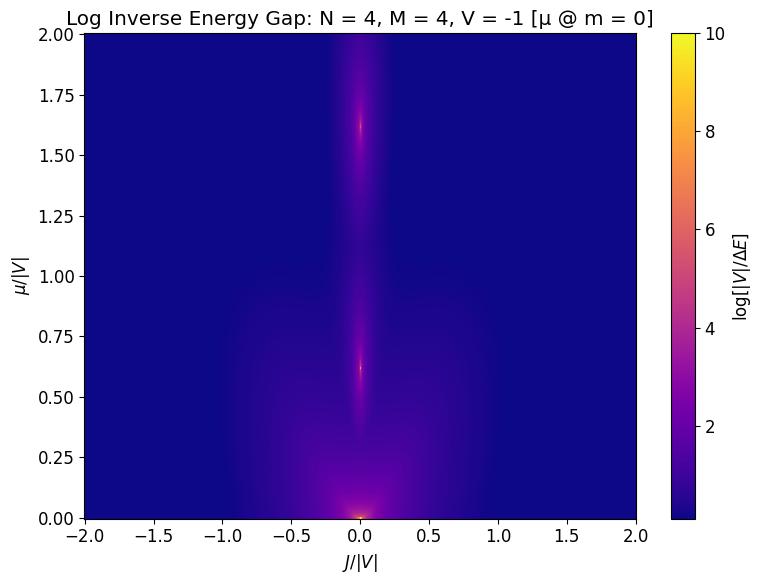

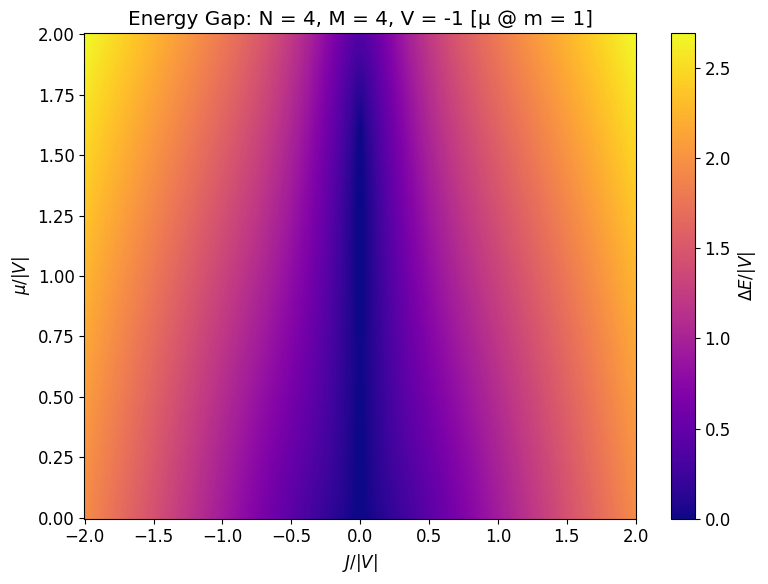

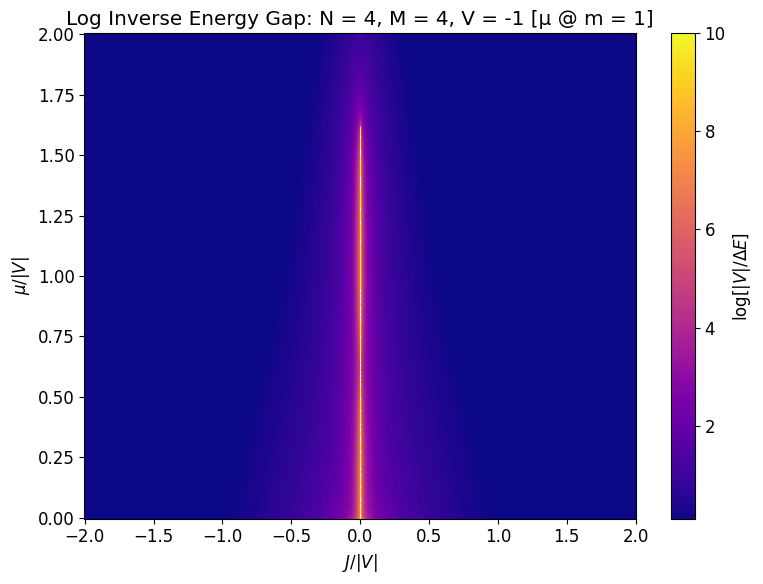

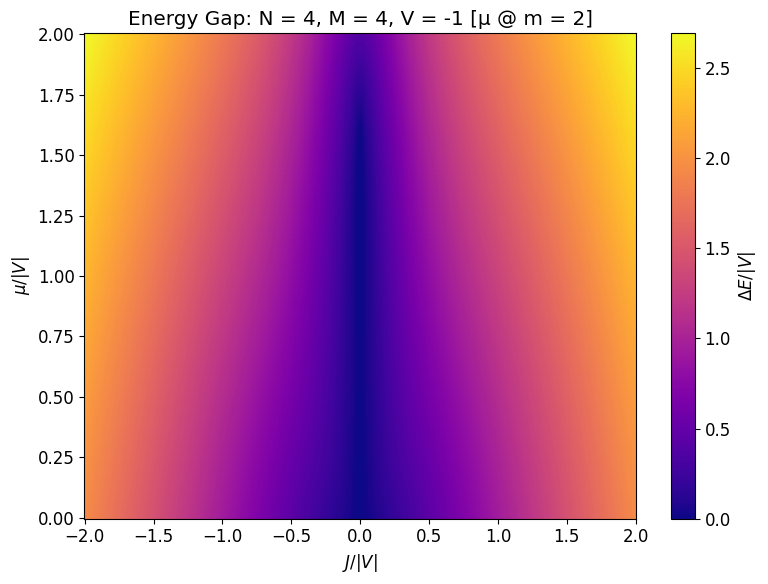

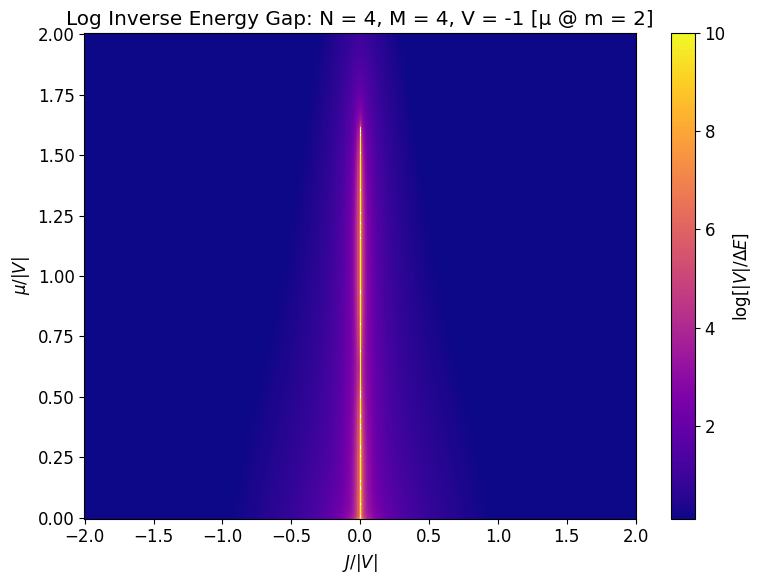

In [3]:
for N in [2,3,4]:
    for M in [2,3,4]:
        for V in [1,-1]:
            for chemical_potential_loc in range(0, M//2 + 1):
                create_energy_gap_plot(N, M, V, mu_bounds = (0,2), J_bounds = (0,2), chemical_potential_loc = chemical_potential_loc, resolution = 250)

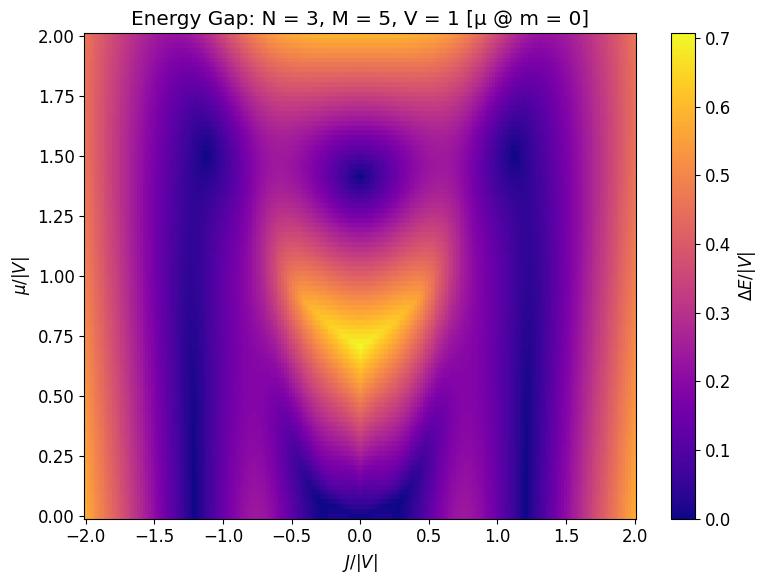

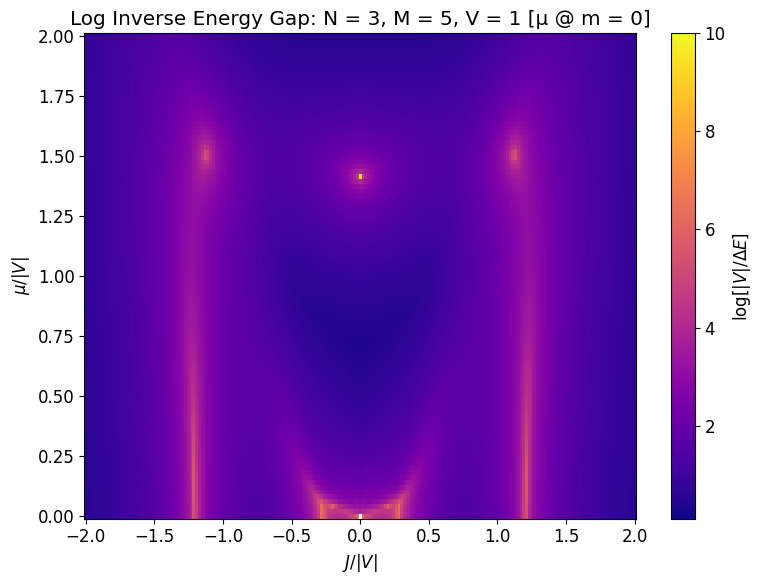

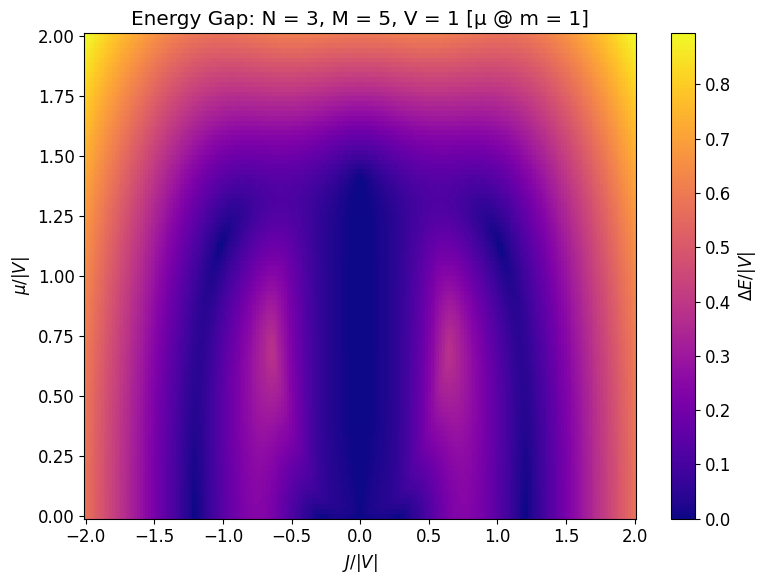

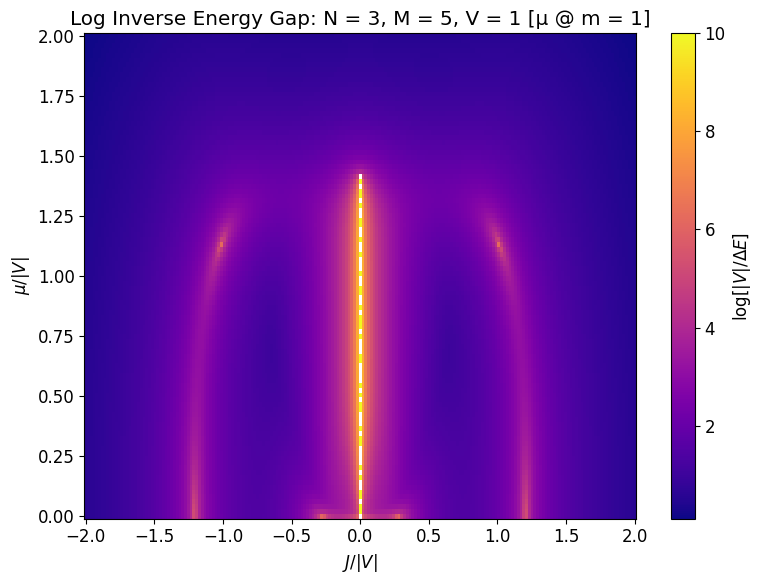

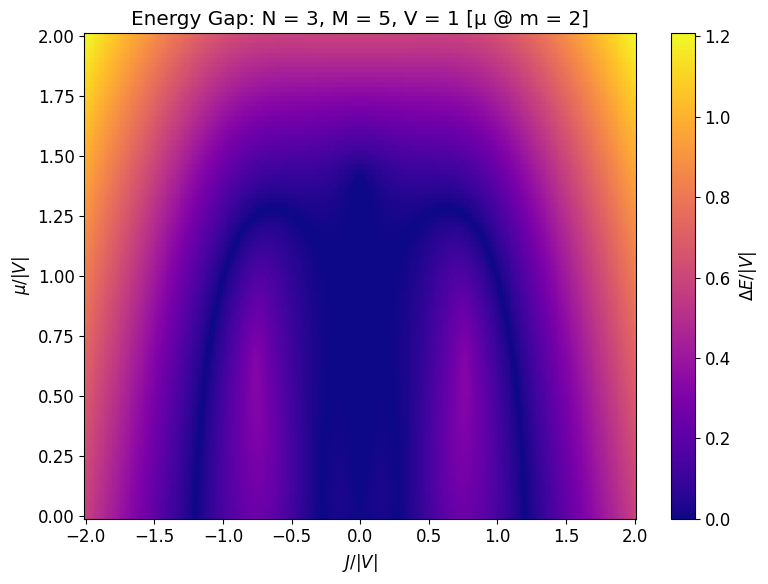

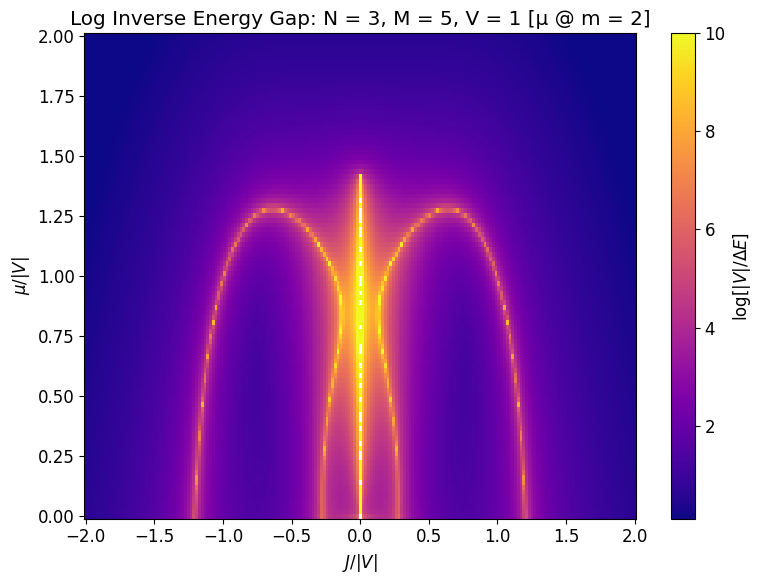

In [5]:
for N in [3]:
    for M in [5]:
        for V in [1]:
            for chemical_potential_loc in range(0, M//2 + 1):
                create_energy_gap_plot(N, M, V, mu_bounds = (0,2), J_bounds = (0,2), chemical_potential_loc = chemical_potential_loc, resolution = 100)